## **Importing Libraries**

In [ ]:
# Importing necessary libraries for data manipulation, visualization, time series analysis,
# scaling, and model building.
import os  # Library for interacting with the operating system
import pickle  # Library for serializing and deserializing Python objects
import pandas as pd  # Library for data manipulation and analysis
import numpy as np  # Library for numerical operations
import matplotlib.pyplot as plt  # Library for creating visualizations
import seaborn as sns  # Library for creating statistical visualizations

## **Loading the Dataset**

In [ ]:
# --- Step 1: Define location and path ---
# Define the location and base path for the data files.
location = "19.32_72.72000000000003"
data_root = "/content/drive/MyDrive/Dataset/Data/pcp"
years = [str(year) for year in range(1996, 2020)] # Create a list of years for which data is available

# --- Step 2: Read and combine all files for this location ---
# Initialize an empty list to store DataFrames for each year.
df_list = []

# Loop through each year, read the corresponding CSV file, and append it to the list.
for year in years:
    file_path = os.path.join(data_root, year, f"{year}_{location}.csv") # Construct the file path
    if os.path.exists(file_path): # Check if the file exists before attempting to read
        df_year = pd.read_csv(file_path) # Read the CSV file into a DataFrame
        df_list.append(df_year) # Append the DataFrame to the list

# Combine all DataFrames in the list into a single DataFrame.
df = pd.concat(df_list, ignore_index=True)
# Convert the 'Time' column to datetime objects and set it as the index.
df['Time'] = pd.to_datetime(df['Time'])
df.set_index('Time', inplace=True)

## **Exploratory Data Analysis and Preprocessing**

Missing values in 'Precipitation':
Count: 0, Percentage: 0.00%


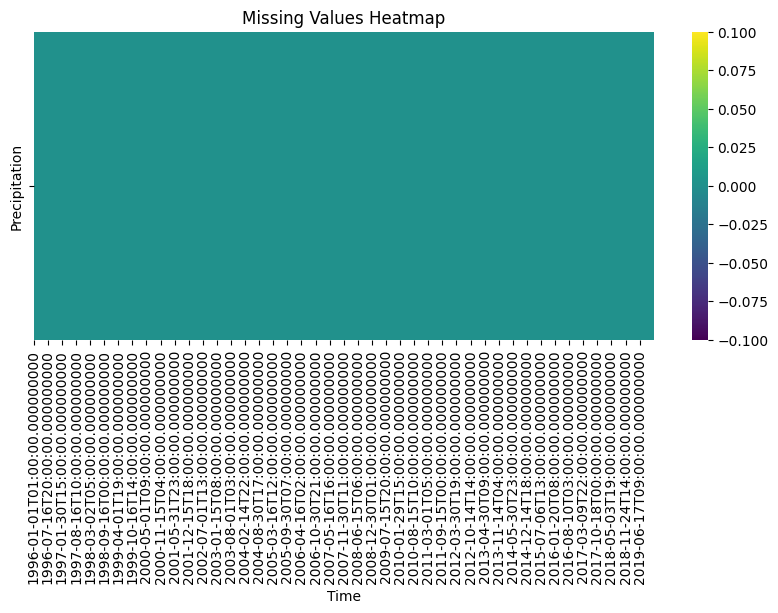

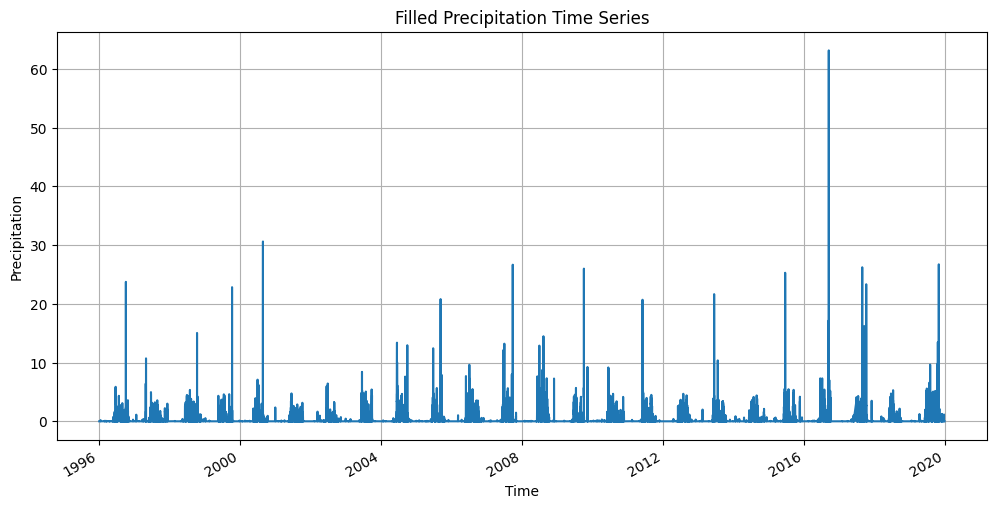

In [ ]:
# Check and print the number and percentage of missing values in the 'Precipitation' column.
print("Missing values in 'Precipitation':")
print(f"Count: {df['Precipitation'].isna().sum()}, Percentage: {df['Precipitation'].isna().mean():.2f}%")

# Visualize missing values using a heatmap.
plt.figure(figsize=(10, 4))
sns.heatmap(df.isna().T, cbar=True, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()
print()
# Fill missing values using interpolation and then forward fill.
df['Precipitation'] = df['Precipitation'].interpolate().ffill()

# Plot the 'Precipitation' time series after filling missing values.
plt.figure(figsize=(12, 6))
df['Precipitation'].plot(title='Filled Precipitation Time Series')
plt.ylabel('Precipitation')
plt.grid(True)
plt.show()

## **Time Series Decomposition**

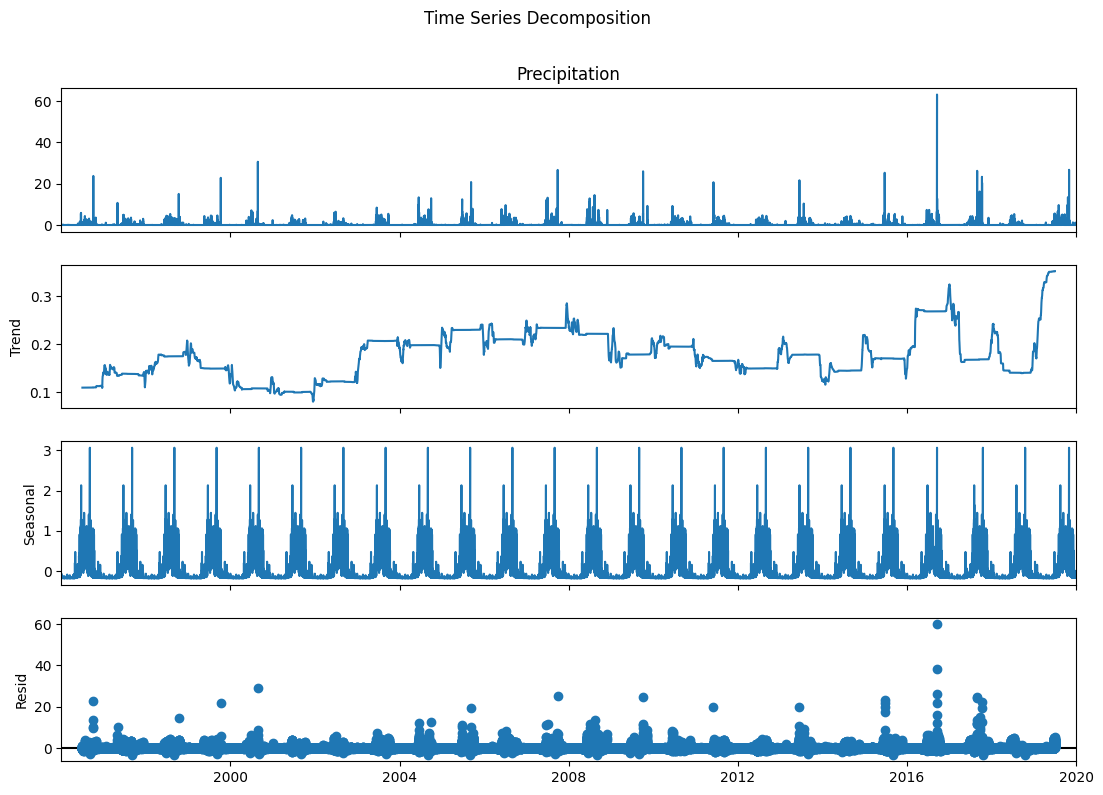

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df['Precipitation'], model='additive', period=8760)

fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.suptitle('Time Series Decomposition', y=1.02)
plt.show()

## **Autocorrelation and Partial Autocorrelation Analysis**

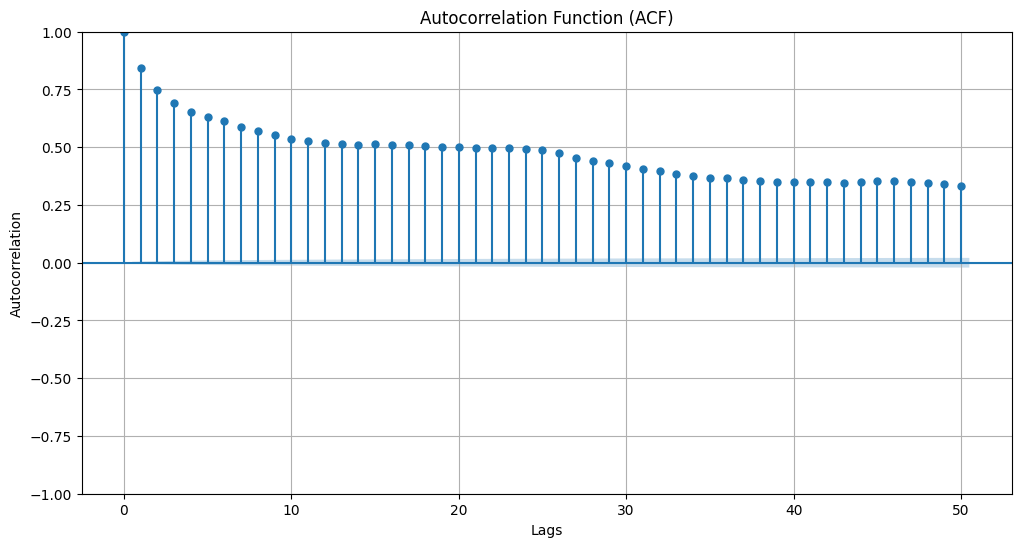

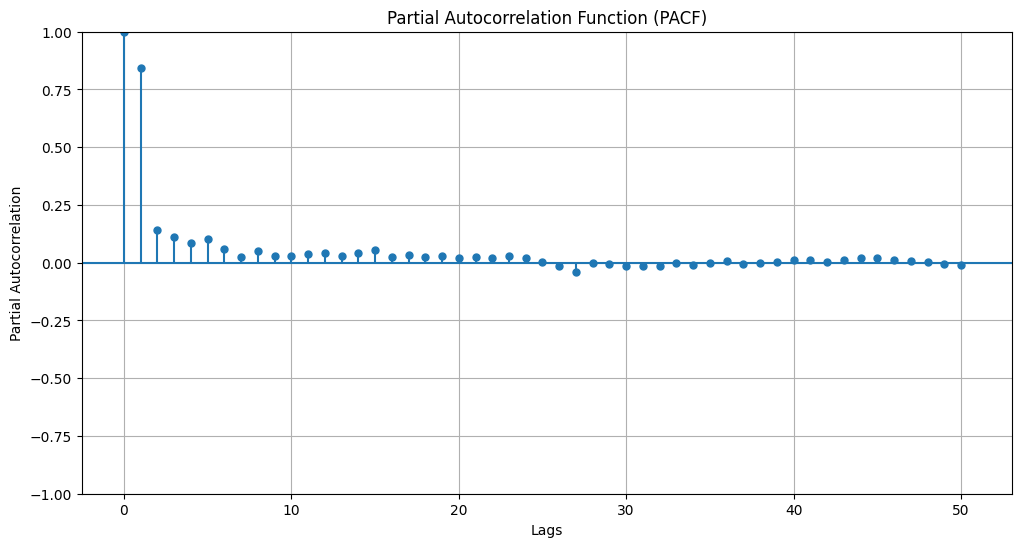

In [ ]:
# Libraries for time series analysis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot the Autocorrelation Function (ACF) to understand the correlation of the series with its lagged values.
plt.figure(figsize=(12, 6))
plot_acf(df['Precipitation'].dropna(), lags=50, ax=plt.gca()) # Dropna to handle any potential NaNs left after decomposition
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

# Plot the Partial Autocorrelation Function (PACF) to understand the direct correlation with lagged values.
plt.figure(figsize=(12, 6))
plot_pacf(df['Precipitation'].dropna(), lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

## **Stationarity Testing (Augmented Dickey-Fuller Test)**

In [ ]:
# Libraries for time series analysis
from statsmodels.tsa.stattools import adfuller

print("Performing Augmented Dickey-Fuller Test:")
adf_test = adfuller(df['Precipitation'])
adf_output = pd.Series(adf_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in adf_test[4].items():
    adf_output['Critical Value (%s)'%key] = value
print(adf_output)

# Interpretation of the test result.
if adf_output['p-value'] <= 0.05:
    print("Result: The time series is likely stationary (reject H0).")
else:
    print("Result: The time series is likely non-stationary (fail to reject H0).")
    print("Consider differencing the data if necessary.")

Performing Augmented Dickey-Fuller Test:
Test Statistic                    -28.979723
p-value                             0.000000
#Lags Used                         72.000000
Number of Observations Used    208792.000000
Critical Value (1%)                -3.430381
Critical Value (5%)                -2.861554
Critical Value (10%)               -2.566777
dtype: float64
Result: The time series is likely stationary (reject H0).


## **Feature Engineering**

In [ ]:
# Create lagged features for precipitation.
# These features can provide the model with information about past precipitation values.
lag_features = [1, 2, 3, 6, 12, 24, 48, 72]
for lag in lag_features:
    # Modified: Use 'df' and 'Precipitation' column
    df[f'Precipitation_lag_{lag}'] = df['Precipitation'].shift(lag) # Shifts the precipitation data by 'lag' periods to create lagged features.

# Create rolling window statistics.
# Rolling statistics can capture local trends and variability.
rolling_window = 24
df['Precipitation_rolling_mean'] = df['Precipitation'].rolling(window=rolling_window).mean() # Calculates the rolling mean over the specified window.
df['Precipitation_rolling_std'] = df['Precipitation'].rolling(window=rolling_window).std() # Calculates the rolling standard deviation over the specified window.

# Create time-based features from the index.
# These features help capture cyclical patterns (daily, weekly, yearly).
df['hour'] = df.index.hour # Extracts the hour of the day from the timestamp.
df['dayofweek'] = df.index.dayofweek # Extracts the day of the week from the timestamp.
df['dayofyear'] = df.index.dayofyear # Extracts the day of the year from the timestamp.
df['month'] = df.index.month # Extracts the month from the timestamp.
df['year'] = df.index.year # Extracts the year from the timestamp.

df.dropna(inplace=True) # Removes rows containing any NaN values.

# Display the first few rows of the DataFrame with new features
print("DataFrame after feature engineering and dropping NaNs:")
display(df.head()) # Displays the head of the DataFrame to show the new features.
display(df.info())

DataFrame after feature engineering and dropping NaNs:


,Precipitation,Precipitation_lag_1,Precipitation_lag_2,Precipitation_lag_3,Precipitation_lag_6,Precipitation_lag_12,Precipitation_lag_24,Precipitation_lag_48,Precipitation_lag_72,Precipitation_rolling_mean,Precipitation_rolling_std,hour,dayofweek,dayofyear,month,year
Time,,,,,,,,,,,,,,,,
1996-01-04 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3,4,1,1996
1996-01-04 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,3,4,1,1996
1996-01-04 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3,4,1,1996
1996-01-04 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,3,4,1,1996
1996-01-04 05:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,3,4,1,1996


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 208793 entries, 1996-01-04 01:00:00 to 2020-01-01 00:00:00
Data columns (total 16 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Precipitation               208793 non-null  float64
 1   Precipitation_lag_1         208793 non-null  float64
 2   Precipitation_lag_2         208793 non-null  float64
 3   Precipitation_lag_3         208793 non-null  float64
 4   Precipitation_lag_6         208793 non-null  float64
 5   Precipitation_lag_12        208793 non-null  float64
 6   Precipitation_lag_24        208793 non-null  float64
 7   Precipitation_lag_48        208793 non-null  float64
 8   Precipitation_lag_72        208793 non-null  float64
 9   Precipitation_rolling_mean  208793 non-null  float64
 10  Precipitation_rolling_std   208793 non-null  float64
 11  hour                        208793 non-null  int32  
 12  dayofweek                   208793 non

None

## **Data Normalization**

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import pickle
import os

# Define the list of features to be used for normalization.
# This includes the 'Precipitation' column and all the engineered features.
features = ['Precipitation'] + [f'Precipitation_lag_{lag}' for lag in [1, 2, 3, 6, 12, 24, 48, 72]] + \
                ['Precipitation_rolling_mean', 'Precipitation_rolling_std', 'hour', 'dayofweek', 'dayofyear', 'month', 'year']

# Instantiate a MinMaxScaler object.
scaler_pcp = MinMaxScaler()

# Apply the MinMaxScaler to the selected features in the DataFrame df.
# Store the scaled data in a new DataFrame.
df_scaled_pcp = scaler_pcp.fit_transform(df[features])
df_scaled_pcp = pd.DataFrame(df_scaled_pcp, columns=features, index=df.index)

# Define the path to save the scaler.
scaler_pcp_path = "/content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Precipitation Data Analysis and Forecasting/model"
os.makedirs(scaler_pcp_path, exist_ok=True)

# Save the fitted MinMaxScaler object to a file using pickle.
scaler_pcp_file = os.path.join(scaler_pcp_path, 'scaler_pcp_features.pkl')
with open(scaler_pcp_file, 'wb') as f:
    pickle.dump(scaler_pcp, f)

print(f"✅ Precipitation data and features normalized. Scaler saved at: {scaler_pcp_file}")

# Display the first few rows of the scaled DataFrame to verify.
display(df_scaled_pcp.head())

✅ Precipitation data and features normalized. Scaler saved at: /content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Precipitation Data Analysis and Forecasting/model/scaler_pcp_features.pkl


,Precipitation,Precipitation_lag_1,Precipitation_lag_2,Precipitation_lag_3,Precipitation_lag_6,Precipitation_lag_12,Precipitation_lag_24,Precipitation_lag_48,Precipitation_lag_72,Precipitation_rolling_mean,Precipitation_rolling_std,hour,dayofweek,dayofyear,month,year
Time,,,,,,,,,,,,,,,,
1996-01-04 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.5,0.008219,0.0,0.0
1996-01-04 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.086957,0.5,0.008219,0.0,0.0
1996-01-04 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.130435,0.5,0.008219,0.0,0.0
1996-01-04 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.173913,0.5,0.008219,0.0,0.0
1996-01-04 05:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.217391,0.5,0.008219,0.0,0.0


## **False Nearest Neighbour(FNN)**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from statsmodels.tsa.stattools import acf

def create_embedding(series, dim, tau):
    N = len(series)
    if N - (dim - 1) * tau <= 0:
        return np.empty((0, dim))
    embedded = np.empty((N - (dim - 1) * tau, dim))
    for i in range(dim):
        embedded[:, i] = series[i * tau : N - (dim - 1 - i) * tau]
    return embedded

def false_nearest_neighbors(series, max_dim=10, tau=1, R_tol=15.0, A_tol=2.0):
    N = len(series)
    raw_fnn_counts = []

    for dim in range(1, max_dim + 1):
        embedded = create_embedding(series, dim, tau)
        embedded_next = create_embedding(series, dim + 1, tau)

        if len(embedded_next) == 0:
            print(f"Dimension {dim}: Not enough data to compute embedding.")
            raw_fnn_counts.append(np.nan)
            continue

        total_points = len(embedded_next)
        false_neighbors = 0

        for i in range(total_points):
            point = embedded[i]
            dists = norm(embedded - point, axis=1)

            dists[i] = np.inf  # exclude self
            # exclude those that can't be mapped to dim+1 embedding
            valid_indices = np.arange(len(embedded_next))
            dists[~np.isin(np.arange(len(embedded)), valid_indices)] = np.inf

            if np.all(np.isinf(dists)):
                false_neighbors += 1
                continue

            nearest_index = np.argmin(dists)
            nearest_dist = dists[nearest_index]
            dist_m1 = abs(embedded_next[i, -1] - embedded_next[nearest_index, -1])

            R = dist_m1 / nearest_dist if nearest_dist != 0 else np.inf
            A = dist_m1

            if R > R_tol or A > A_tol:
                false_neighbors += 1

        raw_fnn_counts.append(false_neighbors)
        print(f"Dimension {dim}: Raw FNN count = {false_neighbors} / {total_points}")

    # Normalize FNN % with respect to dimension 1
    fnn_percentages = np.array(raw_fnn_counts, dtype=float)
    if not np.isnan(fnn_percentages[0]) and fnn_percentages[0] != 0:
        fnn_percentages = (fnn_percentages / fnn_percentages[0]) * 100
    else:
        fnn_percentages[:] = np.nan  # can't normalize

    for i, val in enumerate(fnn_percentages, start=1):
        print(f"Dimension {i}: FNN = {val:.2f}%")

    return fnn_percentages

Chosen delay τ: 62
Dimension 1: Raw FNN count = 19909 / 19938
Dimension 2: Raw FNN count = 18522 / 19876
Dimension 3: Raw FNN count = 16018 / 19814
Dimension 4: Raw FNN count = 14600 / 19752
Dimension 5: Raw FNN count = 13801 / 19690
Dimension 6: Raw FNN count = 13130 / 19628
Dimension 7: Raw FNN count = 12659 / 19566
Dimension 8: Raw FNN count = 12245 / 19504
Dimension 9: Raw FNN count = 11886 / 19442
Dimension 10: Raw FNN count = 11544 / 19380
Dimension 1: FNN = 100.00%
Dimension 2: FNN = 93.03%
Dimension 3: FNN = 80.46%
Dimension 4: FNN = 73.33%
Dimension 5: FNN = 69.32%
Dimension 6: FNN = 65.95%
Dimension 7: FNN = 63.58%
Dimension 8: FNN = 61.50%
Dimension 9: FNN = 59.70%
Dimension 10: FNN = 57.98%


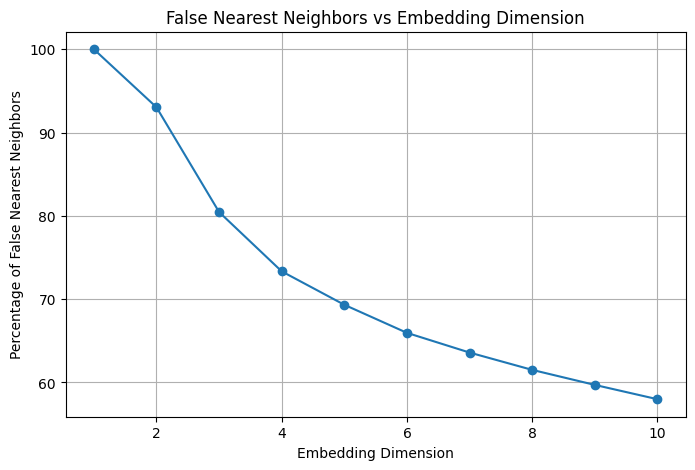

In [ ]:
# Step 1: Extract the scaled precipitation series

precipitation_series_scaled = df_scaled_pcp['Precipitation'].values
short_series = precipitation_series_scaled[-20000:]

# Step 2: Choose delay using ACF
autocorr = acf(short_series, nlags=100)
try:
    tau = next(i for i, val in enumerate(autocorr) if val < 1/np.e)
    print("Chosen delay τ:", tau)
except StopIteration:
    tau = 24
    print("No ACF < 1/e found. Using τ = 24.")

# Step 3: Run FNN algorithm
fnn_results = false_nearest_neighbors(short_series, max_dim=10, tau=tau)

# Step 4: Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), fnn_results, marker='o', linestyle='-')
plt.title("False Nearest Neighbors vs Embedding Dimension")
plt.xlabel("Embedding Dimension")
plt.ylabel("Percentage of False Nearest Neighbors")
plt.grid(True)
plt.ylim(0, 100)  # Set the y-axis limits from 0 to 100
plt.show()

Chosen delay τ: 1
Dimension 1: Raw FNN count = 19969 / 19999
Dimension 2: Raw FNN count = 18625 / 19998
Dimension 3: Raw FNN count = 16233 / 19997
Dimension 4: Raw FNN count = 15028 / 19996
Dimension 5: Raw FNN count = 14499 / 19995
Dimension 6: Raw FNN count = 14161 / 19994
Dimension 7: Raw FNN count = 13917 / 19993
Dimension 8: Raw FNN count = 13733 / 19992
Dimension 9: Raw FNN count = 13578 / 19991
Dimension 10: Raw FNN count = 13443 / 19990
Dimension 1: FNN = 100.00%
Dimension 2: FNN = 93.27%
Dimension 3: FNN = 81.29%
Dimension 4: FNN = 75.26%
Dimension 5: FNN = 72.61%
Dimension 6: FNN = 70.91%
Dimension 7: FNN = 69.69%
Dimension 8: FNN = 68.77%
Dimension 9: FNN = 68.00%
Dimension 10: FNN = 67.32%


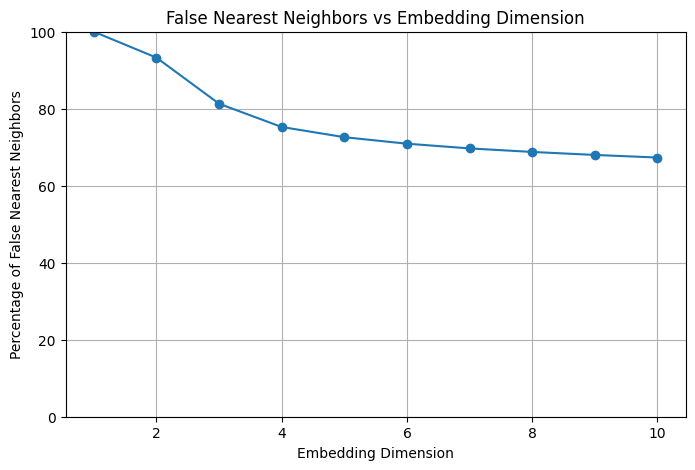

In [ ]:
# Step 1: Extract the scaled precipitation series

precipitation_series_scaled = df_scaled_pcp['Precipitation'].values
short_series = precipitation_series_scaled[-20000:]

# Step 2: Choose delay using ACF
# autocorr = acf(short_series, nlags=100)
# try:
tau = 1
print("Chosen delay τ:", tau)
# except StopIteration:
#     tau = 24
#     print("No ACF < 1/e found. Using τ = 24.")

# Step 3: Run FNN algorithm
fnn_results = false_nearest_neighbors(short_series, max_dim=10, tau=tau)
# Step 4: Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), fnn_results, marker='o', linestyle='-')
plt.title("False Nearest Neighbors vs Embedding Dimension")
plt.xlabel("Embedding Dimension")
plt.ylabel("Percentage of False Nearest Neighbors")
plt.grid(True)
plt.ylim(0, 100)  # Set the y-axis limits from 0 to 100
plt.show()

## **Prepare Data for LSTM Models**

In [ ]:
import numpy as np # Imports the NumPy library for numerical operations and array manipulation.

# Define a function to create sequences for single-step prediction with multiple features.
def to_sequences_multi_feature_pcp(data, seq_len=24):
    x, y = [], [] # Initializes empty lists to store input sequences (x) and output values (y).
    # Assuming 'Precipitation' (the target) is the first column in the scaled data
    target_column_index = 0 # Defines the index of the target column ('Precipitation').
    for i in range(len(data) - seq_len): # Loops through the data to create sequences.
        x.append(data[i : i + seq_len])  # Slices the data to create an input sequence of length seq_len and appends it to x.
        y.append(data[i + seq_len, target_column_index])  # Appends the target value (from the target column) at the time step after the sequence to y.
    return np.array(x), np.array(y) # Converts the lists x and y to NumPy arrays and returns them.

# Generate single-step sequences for the scaled precipitation data.
sequence_length = 24  # Use 24 hours as input to predict next hour
precipitation_array = df_scaled_pcp.values # Get numpy array from scaled dataframe
X_single, y_single = to_sequences_multi_feature_pcp(
    precipitation_array, sequence_length
) # Calls the function to generate single-step sequences.

# Reshape for LSTM: (samples, timesteps, features)
X_single = X_single.reshape(
    (X_single.shape[0], X_single.shape[1], X_single.shape[2])
) # Reshapes the input sequences to the 3D format required by LSTM layers: [samples, timesteps, features].


# Define a function to create multi-step sequences for multi-feature LSTM.
def to_multi_sequences_pcp(data, inp=24, out=24):
    X, y = [], [] # Initializes empty lists for input sequences (X) and output sequences (y).
    # Assuming 'Precipitation' (the target) is the first column in the scaled data
    target_column_index = 0 # Defines the index of the target column.
    for i in range(len(data) - inp - out + 1): # Loops through the data to create multi-step sequences.
        X.append(data[i : i + inp])  # Slices the data to create an input sequence of length inp and appends it to X.
        y.append(
            data[i + inp : i + inp + out, target_column_index]
        )  # Slices the target column to create an output sequence of length out and appends it to y.
    return np.array(X), np.array(y) # Converts the lists X and y to NumPy arrays and returns them.

# Generate multi-step sequences for the scaled precipitation data.
inp_length = 24  # Input sequence length
out_length = 24  # Output sequence length (e.g., predict next 6 hours)
X_multi, y_multi = to_multi_sequences_pcp(
    df_scaled_pcp.values, inp=inp_length, out=out_length
) # Calls the function to generate multi-step sequences.

# Reshape the multi-step input data for the LSTM layer (samples, time steps, features).
X_multi = X_multi.reshape(
    (X_multi.shape[0], X_multi.shape[1], X_multi.shape[2])
) # Reshapes the multi-step input sequences to the 3D LSTM format.

# Print the shapes of the generated sequences
print(f"Shape of single-step X_single: {X_single.shape}")
print(f"Shape of single-step y_single: {y_single.shape}")
print(f"Shape of multi-step X_multi: {X_multi.shape}")
print(f"Shape of multi-step y_multi: {y_multi.shape}")

Shape of single-step X_single: (208769, 24, 16)
Shape of single-step y_single: (208769,)
Shape of multi-step X_multi: (208746, 24, 16)
Shape of multi-step y_multi: (208746, 24)


## **Split Data**

In [ ]:
# Determine the split index for single-step data (80% for training)
split_index_single = int(0.8 * len(X_single)) # Calculate the index for an 80/20 split based on the number of single-step sequences.

# Split the single-step data
X_train_single, X_val_single = X_single[:split_index_single], X_single[split_index_single:] # Split the single-step input data (X) into training and validation sets based on the calculated index.
y_train_single, y_val_single = y_single[:split_index_single], y_single[split_index_single:] # Split the single-step target data (y) into training and validation sets using the same index.

# Determine the split index for multi-step data (using the same proportion)
split_index_multi = int(0.8 * len(X_multi)) # Calculate the index for an 80/20 split based on the number of multi-step sequences.

# Split the multi-step data
X_train_multi, X_val_multi = X_multi[:split_index_multi], X_multi[split_index_multi:] # Split the multi-step input data (X) into training and validation sets.
y_train_multi, y_val_multi = y_multi[:split_index_multi], y_multi[split_index_multi:] # Split the multi-step target data (y) into training and validation sets.

# Print the shapes of the resulting training and validation sets
print("Single-step data shapes:") # Print a header for single-step data shapes.
print(f"X_train_single shape: {X_train_single.shape}") # Print the shape of the single-step training input data.
print(f"X_val_single shape: {X_val_single.shape}") # Print the shape of the single-step validation input data.
print(f"y_train_single shape: {y_train_single.shape}") # Print the shape of the single-step training target data.
print(f"y_val_single shape: {y_val_single.shape}") # Print the shape of the single-step validation target data.
print("\nMulti-step data shapes:") # Print a header for multi-step data shapes.
print(f"X_train_multi shape: {X_train_multi.shape}") # Print the shape of the multi-step training input data.
print(f"X_val_multi shape: {X_val_multi.shape}") # Print the shape of the multi-step validation input data.
print(f"y_train_multi shape: {y_train_multi.shape}") # Print the shape of the multi-step training target data.
print(f"y_val_multi shape: {y_val_multi.shape}") # Print the shape of the multi-step validation target data.

Single-step data shapes:
X_train_single shape: (167015, 24, 16)
X_val_single shape: (41754, 24, 16)
y_train_single shape: (167015,)
y_val_single shape: (41754,)

Multi-step data shapes:
X_train_multi shape: (166996, 24, 16)
X_val_multi shape: (41750, 24, 16)
y_train_multi shape: (166996, 24)
y_val_multi shape: (41750, 24)


## **Build Vanilla Single-Step LSTM Model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the input shape for the single-step model
# X_train_single has shape (samples, timesteps, features)
input_shape_single = (X_train_single.shape[1], X_train_single.shape[2]) # (timesteps, features)

# Build the Vanilla LSTM model
model_vanilla_single = Sequential([
    # Single LSTM layer
    LSTM(50, input_shape=input_shape_single), # 50 units, input shape is (timesteps, features)

    # Output layer for single-step prediction
    Dense(1, activation='linear') # 1 unit for the next single precipitation value (using linear for precipitation)
])

# Compile the model
model_vanilla_single.compile(optimizer='adam', loss='mse') # Use Adam optimizer and Mean Squared Error loss

# Print the model summary
print("Vanilla Single-Step LSTM Model Summary:")
model_vanilla_single.summary()

Vanilla Single-Step LSTM Model Summary:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        13,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,451 (52.54 KB)

 Trainable params: 13,451 (52.54 KB)

 Non-trainable params: 0 (0.00 B)

## **Train Vanilla Single-Step LSTM Model**

Epoch 1/4
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 59s 22ms/step - loss: 2.0939e-04 - val_loss: 8.0603e-05
Epoch 2/4
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 80s 21ms/step - loss: 2.4544e-05 - val_loss: 8.1586e-05
Epoch 3/4
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 82s 21ms/step - loss: 2.3747e-05 - val_loss: 7.2911e-05
Epoch 4/4
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 85s 22ms/step - loss: 2.8850e-05 - val_loss: 7.4139e-05


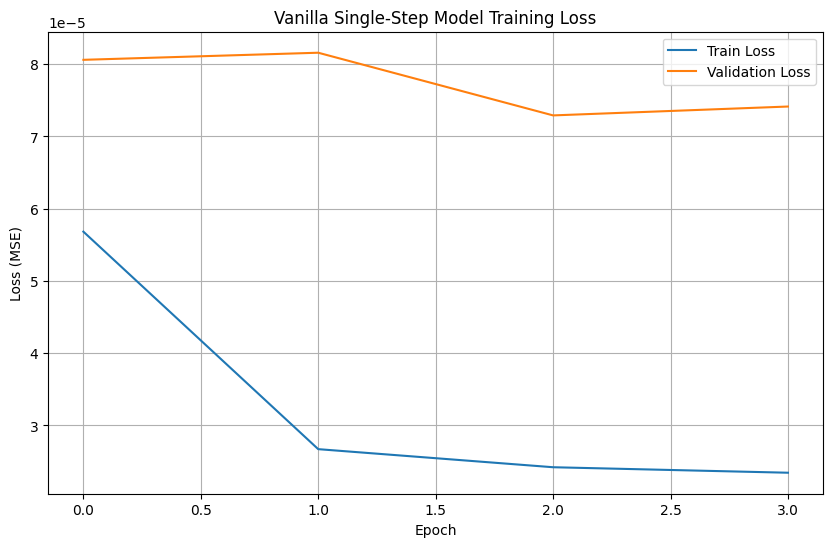

In [ ]:
import matplotlib.pyplot as plt

# Compile the model
model_vanilla_single.compile(optimizer='adam', loss='mse')

# Train the model
history_vanilla_single = model_vanilla_single.fit(X_train_single, y_train_single,
                                           epochs=4,
                                           batch_size=64,
                                           validation_data=(X_val_single, y_val_single))

# Plot the training and validation loss over epochs.
plt.figure(figsize=(10, 6))
plt.plot(history_vanilla_single.history['loss'], label='Train Loss')
plt.plot(history_vanilla_single.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Vanilla Single-Step Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.grid(True)
plt.show()

## **Save Vanilla Single-Step LSTM Model and Scaler**

In [ ]:
import os
import pickle
from tensorflow.keras.models import save_model

# Define the path to save the single-step models and scalers
single_step_model_path = "/content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Precipitation Data Analysis and Forecasting/singlestep_model" # Updated path

os.makedirs(single_step_model_path, exist_ok=True)

# Define the path to save the Vanilla Single-Step LSTM model and scaler.
model_vanilla_single_file = os.path.join(single_step_model_path, 'lstm_model_vanilla_single_pcp.h5') # Updated filename
scaler_vanilla_single_file = os.path.join(single_step_model_path, 'scaler_vanilla_single_pcp_features.pkl') # Updated filename

# Save the trained Vanilla Single-Step LSTM model in .h5 format.
save_model(model_vanilla_single, model_vanilla_single_file)

# Save the fitted MinMaxScaler (assuming scaler_pcp is the one used for normalization).
# Make sure 'scaler_pcp' variable is available in the environment.
if 'scaler_pcp' in locals():
    with open(scaler_vanilla_single_file, 'wb') as f:
        pickle.dump(scaler_pcp, f) # Use scaler_pcp that was fitted earlier
    print("✅ Vanilla Single-Step LSTM Precipitation Model and Scaler saved successfully.")
    print(f"Model saved at: {model_vanilla_single_file}")
    print(f"Scaler saved at: {scaler_vanilla_single_file}")
else:
    print("❌ Error: 'scaler_pcp' variable not found. Cannot save scaler.")

✅ Vanilla Single-Step LSTM Precipitation Model and Scaler saved successfully.
Model saved at: /content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Precipitation Data Analysis and Forecasting/singlestep_model/lstm_model_vanilla_single_pcp.h5
Scaler saved at: /content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Precipitation Data Analysis and Forecasting/singlestep_model/scaler_vanilla_single_pcp_features.pkl


## **Implement Stacked Single-Step LSTM Model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the input shape based on your training data X_train_single
n_steps = X_train_single.shape[1] # Number of time steps in each sequence
n_features = X_train_single.shape[2] # Number of features at each time step

# Define the simple stacked LSTM model
model_stacked_single = Sequential()
model_stacked_single.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features))) # First LSTM layer, returns sequences for stacking
model_stacked_single.add(LSTM(50, activation='relu')) # Second LSTM layer, outputs a single vector
model_stacked_single.add(Dense(1, activation='linear')) # Output layer for single-step prediction (using linear for precipitation)

# Compile the model (using the same optimizer and loss as before for comparison)
model_stacked_single.compile(optimizer='adam', loss='mse')

# Print the model summary
print("Stacked Single-Step LSTM Model Summary:")
model_stacked_single.summary()

Stacked Single-Step LSTM Model Summary:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 24, 50)         │        13,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,651 (131.45 KB)

 Trainable params: 33,651 (131.45 KB)

 Non-trainable params: 0 (0.00 B)

## **Train Stacked Single-Step LSTM Model**

Epoch 1/6
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 111s 42ms/step - loss: 3.5063e-05 - val_loss: 8.5333e-05
Epoch 2/6
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 140s 42ms/step - loss: 2.7175e-05 - val_loss: 6.8161e-05
Epoch 3/6
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 109s 42ms/step - loss: 2.2029e-05 - val_loss: 6.9325e-05
Epoch 4/6
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 142s 42ms/step - loss: 2.2780e-05 - val_loss: 6.5948e-05
Epoch 5/6
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 141s 42ms/step - loss: 2.2366e-05 - val_loss: 7.1153e-05
Epoch 6/6
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 142s 42ms/step - loss: 2.2105e-05 - val_loss: 6.4548e-05


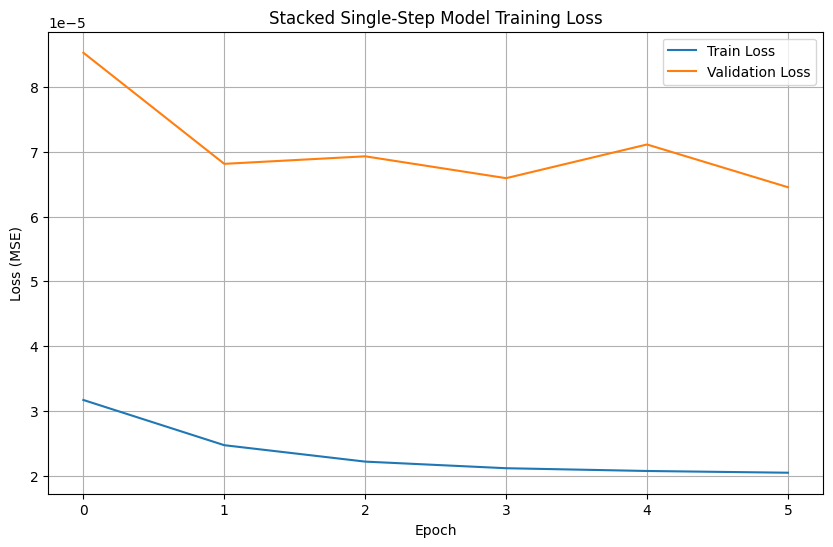

In [ ]:
# Train the model
history_stacked_single = model_stacked_single.fit(X_train_single, y_train_single,
                                                        epochs=6, # Use the same number of epochs as previous models for consistency
                                                        batch_size=64, # Use a typical batch size
                                                        validation_data=(X_val_single, y_val_single)) # Use validation data to monitor performance

import matplotlib.pyplot as plt
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history_stacked_single.history['loss'], label='Train Loss')
plt.plot(history_stacked_single.history['val_loss'], label='Validation Loss')
plt.title('Stacked Single-Step Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

## **Save Stacked Single-Step LSTM Model and Scaler**

In [ ]:
import os
import pickle
from tensorflow.keras.models import save_model

# Define the path to save the simple Stacked LSTM model and scaler.
stacked_single_model_path = "/content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Precipitation Data Analysis and Forecasting/singlestep_model" # Updated path

os.makedirs(stacked_single_model_path, exist_ok=True)

# Define the path to save the Stacked Single-Step LSTM model and scaler.
model_stacked_single_file = os.path.join(stacked_single_model_path, 'lstm_model_stacked_single_pcp.h5') # Updated filename
scaler_stacked_single_file = os.path.join(stacked_single_model_path, 'scaler_stacked_single_pcp_features.pkl') # Updated filename

# Save the trained Stacked Single-Step LSTM model in .h5 format.
save_model(model_stacked_single, model_stacked_single_file)

# Save the fitted MinMaxScaler (assuming scaler_pcp is the one used for normalization).
# Make sure 'scaler_pcp' variable is available in the environment.
if 'scaler_pcp' in locals():
    with open(scaler_stacked_single_file, 'wb') as f:
        pickle.dump(scaler_pcp, f) # Use scaler_pcp that was fitted earlier

    print("✅ Stacked Single-Step LSTM Precipitation Model and Scaler saved successfully.")
    print(f"Model saved at: {model_stacked_single_file}")
    print(f"Scaler saved at: {scaler_stacked_single_file}")
else:
    print("❌ Error: 'scaler_pcp' variable not found. Cannot save scaler.")

✅ Stacked Single-Step LSTM Precipitation Model and Scaler saved successfully.
Model saved at: /content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Precipitation Data Analysis and Forecasting/singlestep_model/lstm_model_stacked_single_pcp.h5
Scaler saved at: /content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Precipitation Data Analysis and Forecasting/singlestep_model/scaler_stacked_single_pcp_features.pkl


## **Implement Bidirectional Single-Step LSTM Model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional

# Define the input shape for the Bidirectional LSTM model
# Use the shape of the single-step training data, excluding the number of samples
input_shape_single = (X_train_single.shape[1], X_train_single.shape[2])

# Build the Bidirectional LSTM model
model_bidirectional_single = Sequential([
    # Bidirectional LSTM layer wrapping an LSTM layer
    Bidirectional(LSTM(50, return_sequences=False), # 50 LSTM units, return_sequences=False for single output per sequence
                  input_shape=input_shape_single), # Define input shape

    # Output layer for single-step prediction
    Dense(1, activation='linear') # Single output neuron with linear activation for precipitation
])

# Compile the model
model_bidirectional_single.compile(optimizer='adam', loss='mse') # Use Adam optimizer and Mean Squared Error loss

# Print the model summary
print("Bidirectional Single-Step LSTM Model Summary:")
model_bidirectional_single.summary()

Bidirectional Single-Step LSTM Model Summary:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 100)            │        26,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,901 (105.08 KB)

 Trainable params: 26,901 (105.08 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 89s 32ms/step - loss: 1.7719e-04 - val_loss: 7.5007e-05
Epoch 2/6
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 149s 35ms/step - loss: 2.7831e-05 - val_loss: 7.3760e-05
Epoch 3/6
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 144s 36ms/step - loss: 2.4354e-05 - val_loss: 7.4603e-05
Epoch 4/6
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 152s 40ms/step - loss: 2.7347e-05 - val_loss: 7.0658e-05
Epoch 5/6
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 129s 35ms/step - loss: 2.4348e-05 - val_loss: 6.6650e-05
Epoch 6/6
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 138s 34ms/step - loss: 2.2471e-05 - val_loss: 6.9739e-05


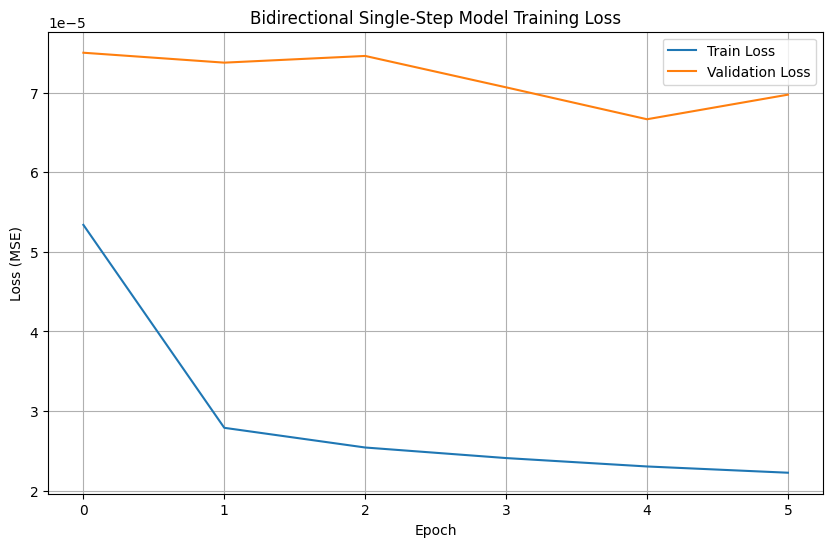

In [ ]:
import matplotlib.pyplot as plt

# Train the model
history_bidirectional_single = model_bidirectional_single.fit(X_train_single, y_train_single,
                                                      epochs=6,
                                                      batch_size=64,
                                                      validation_data=(X_val_single, y_val_single))

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history_bidirectional_single.history['loss'], label='Train Loss')
plt.plot(history_bidirectional_single.history['val_loss'], label='Validation Loss')
plt.title('Bidirectional Single-Step Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

## **Save Bidirectional Single-Step LSTM Model and Scaler**

In [ ]:
import os
import pickle
from tensorflow.keras.models import save_model

# Define the path to save the single-step models and scalers
bidirectional_single_model_path = "/content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Precipitation Data Analysis and Forecasting/singlestep_model" # Updated path

os.makedirs(bidirectional_single_model_path, exist_ok=True)

# Define the path to save the Bidirectional Single-Step LSTM model and scaler.
model_bidirectional_single_file = os.path.join(bidirectional_single_model_path, 'lstm_model_bidirectional_single_pcp.h5') # Updated filename
scaler_bidirectional_single_file = os.path.join(bidirectional_single_model_path, 'scaler_bidirectional_single_pcp_features.pkl') # Updated filename

# Save the trained Bidirectional Single-Step LSTM model in .h5 format.
save_model(model_bidirectional_single, model_bidirectional_single_file)

# Save the fitted MinMaxScaler (assuming scaler_pcp is the one used for normalization).
# Make sure 'scaler_pcp' variable is available in the environment.
if 'scaler_pcp' in locals():
    with open(scaler_bidirectional_single_file, 'wb') as f:
        pickle.dump(scaler_pcp, f) # Use scaler_pcp that was fitted earlier

    print("✅ Bidirectional Single-Step LSTM Precipitation Model and Scaler saved successfully.")
    print(f"Model saved at: {model_bidirectional_single_file}")
    print(f"Scaler saved at: {scaler_bidirectional_single_file}")
else:
    print("❌ Error: 'scaler_pcp' variable not found. Cannot save scaler.")

✅ Bidirectional Single-Step LSTM Precipitation Model and Scaler saved successfully.
Model saved at: /content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Precipitation Data Analysis and Forecasting/singlestep_model/lstm_model_bidirectional_single_pcp.h5
Scaler saved at: /content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Precipitation Data Analysis and Forecasting/singlestep_model/scaler_bidirectional_single_pcp_features.pkl


## **Evaluate and Compare Single-Step LSTM Models**

✅ Vanilla Single-Step model loaded for comparison.
✅ Stacked Single-Step model loaded for comparison.


✅ Bidirectional Single-Step model loaded for comparison.
✅ Scaler loaded successfully from /content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Precipitation Data Analysis and Forecasting/singlestep_model/scaler_vanilla_single_pcp_features.pkl.
✅ True single-step validation values inverse transformed for metric calculation.
✅ Single-step validation timestamps aligned.
1305/1305 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
✅ Predictions made for Vanilla Single-Step LSTM.
1305/1305 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step
✅ Predictions made for Stacked Single-Step LSTM.
1305/1305 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step
✅ Predictions made for Bidirectional Single-Step LSTM.

Vanilla LSTM Evaluation:
  MAE: 0.2422
  RMSE: 0.5432
  R2: 0.6304

Stacked LSTM Evaluation:
  MAE: 0.0949
  RMSE: 0.5075
  R2: 0.6774

Bidirectional LSTM Evaluation:
  MAE: 0.0988
  RMSE: 0.5257
  R2: 0.6539


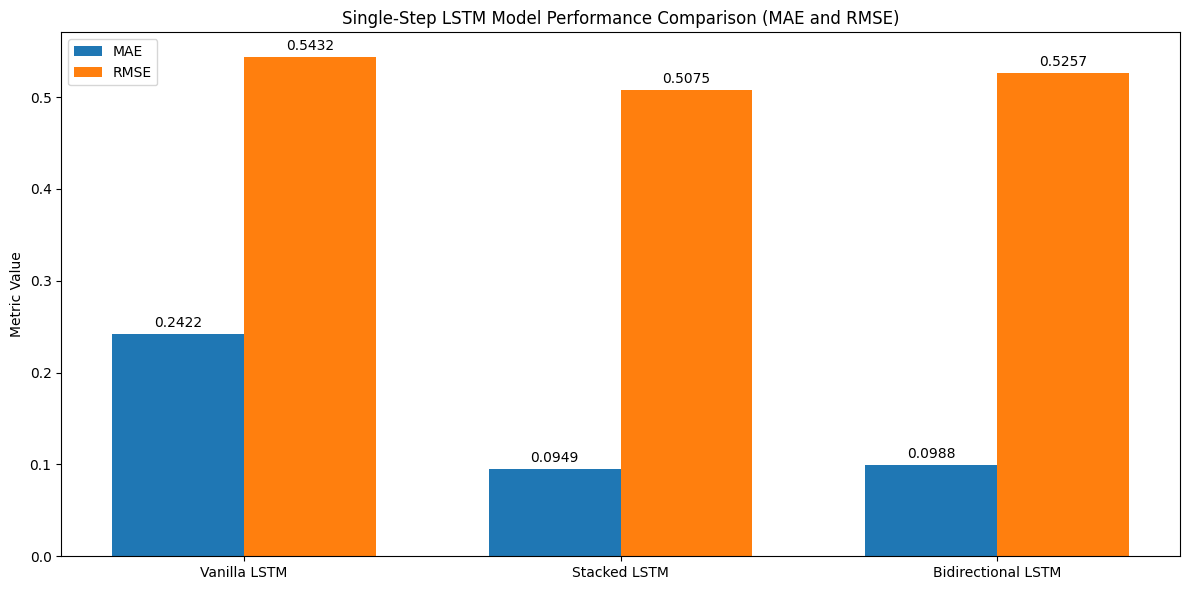

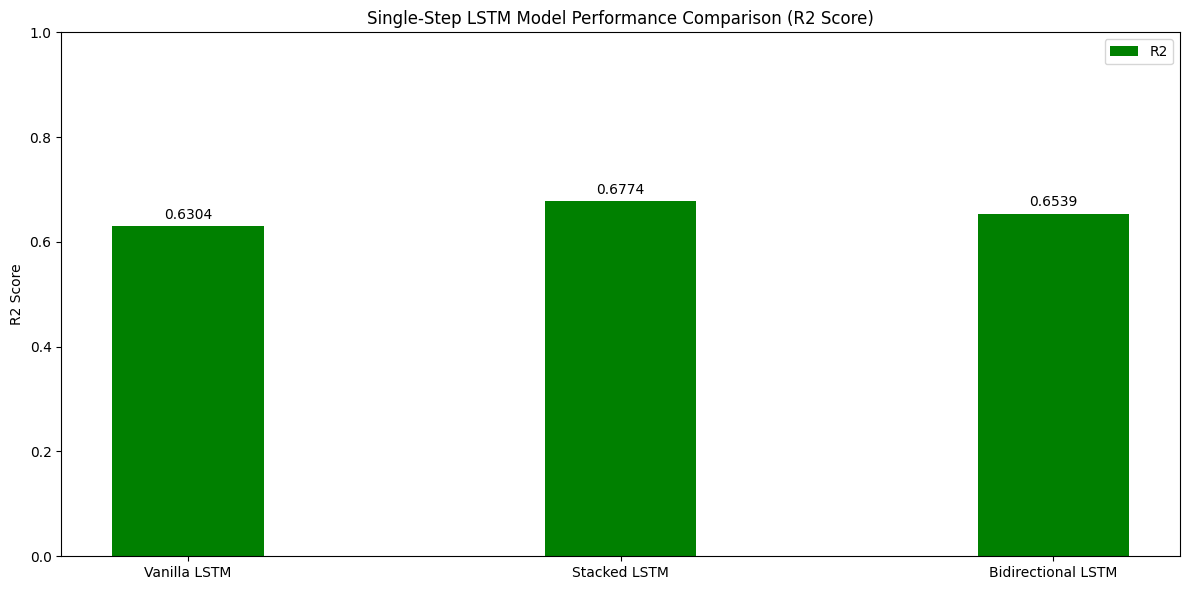



--- Best Single-Step Model (Stacked LSTM) Predictions on Validation Data (First 200 points) ---


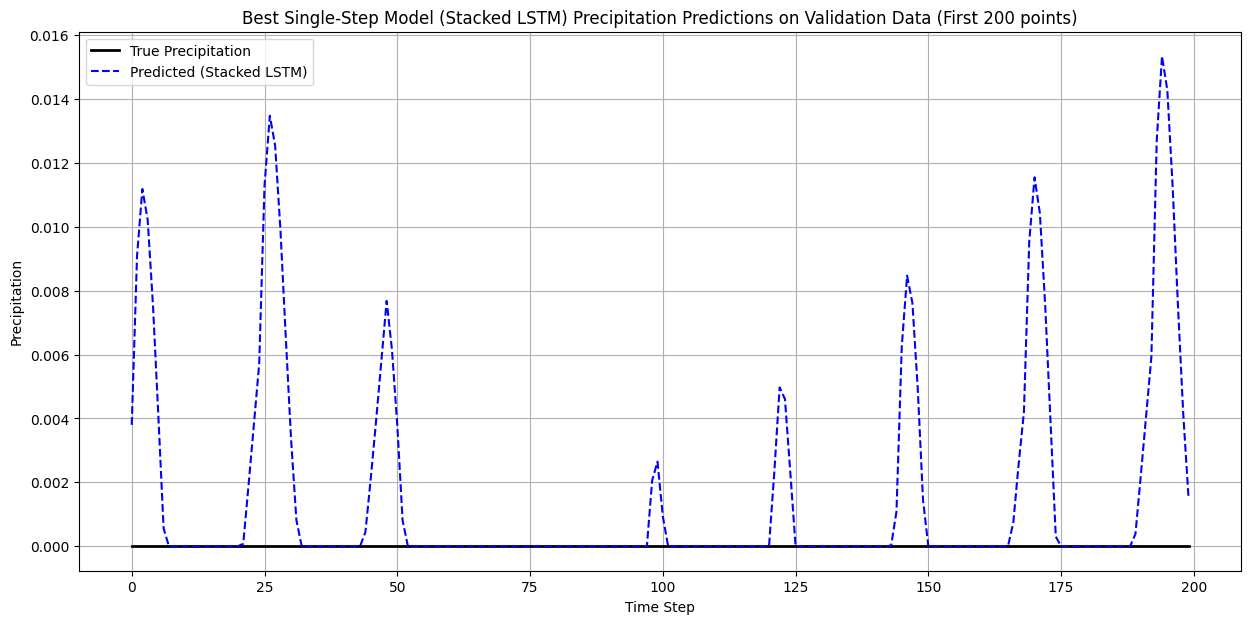


--- Best Single-Step Model (Stacked LSTM) Predictions on Validation Data (Full Validation Set) ---


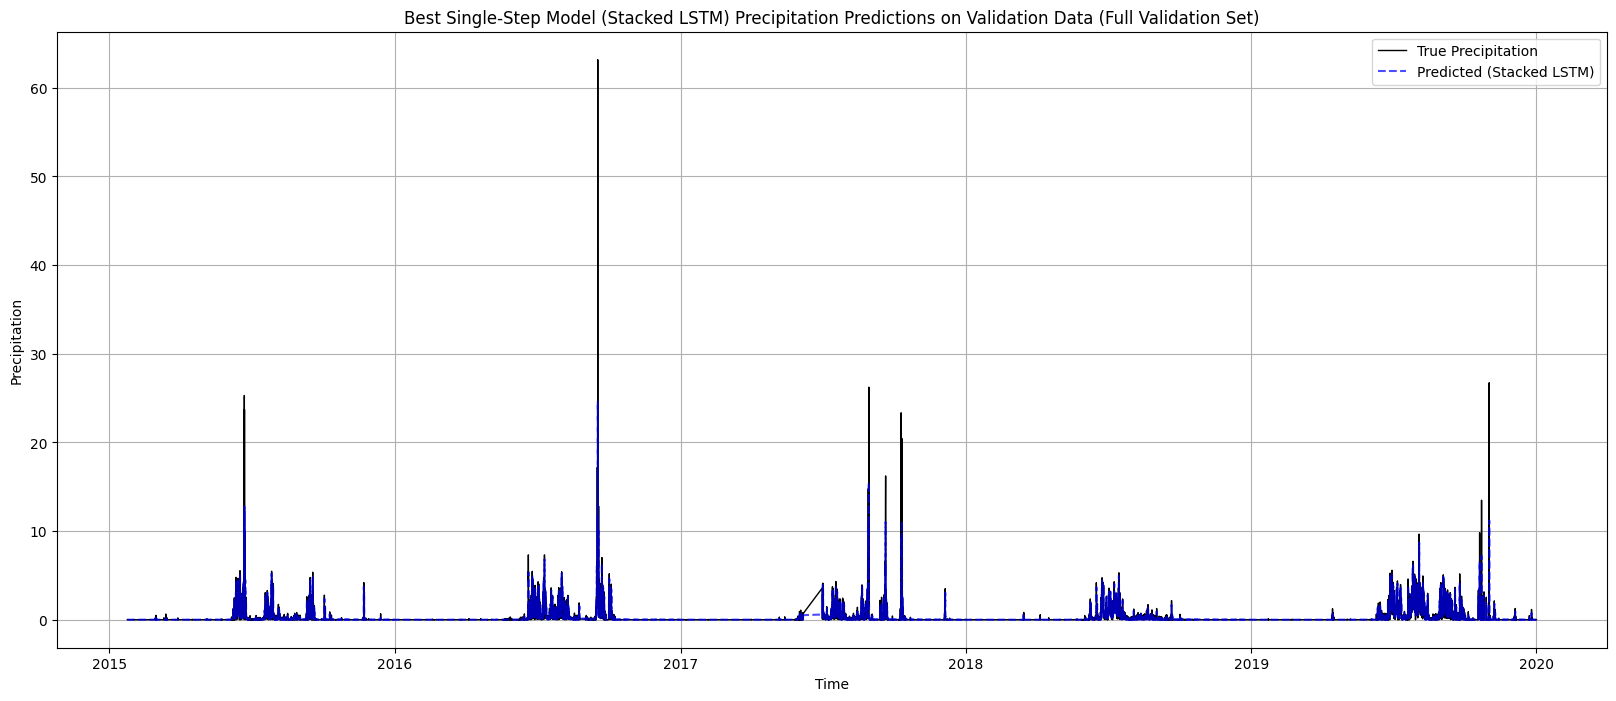


--- Scatter Plot: Predicted vs Observed (Single-Step Models) ---


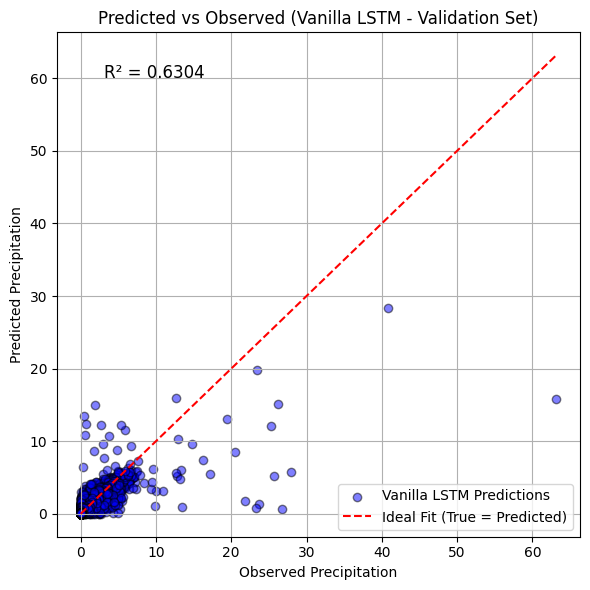

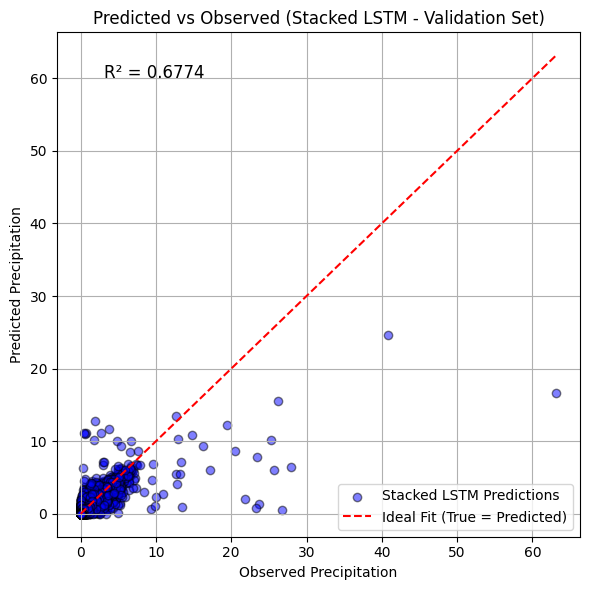

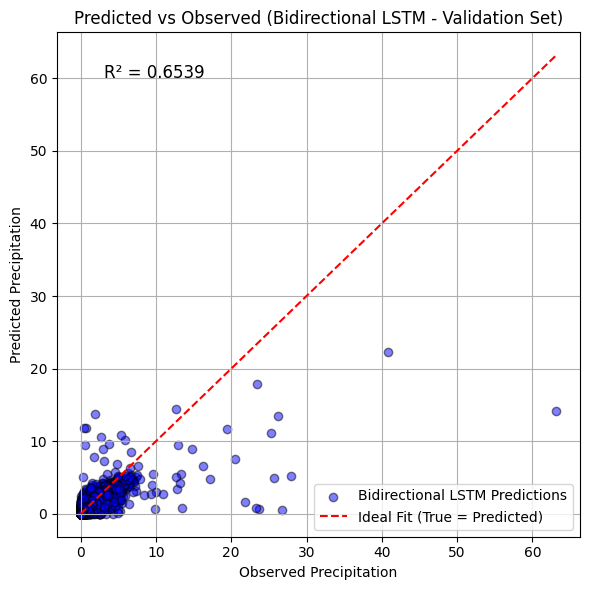


--- Making Future Forecast with Stacked LSTM Model ---
✅ Data prepared for future single-step forecasting. Input shape: (1, 24, 16)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step

Best Single-Step Model (Stacked LSTM) Forecast for 2020-01-01 01:00:00: 0.0149


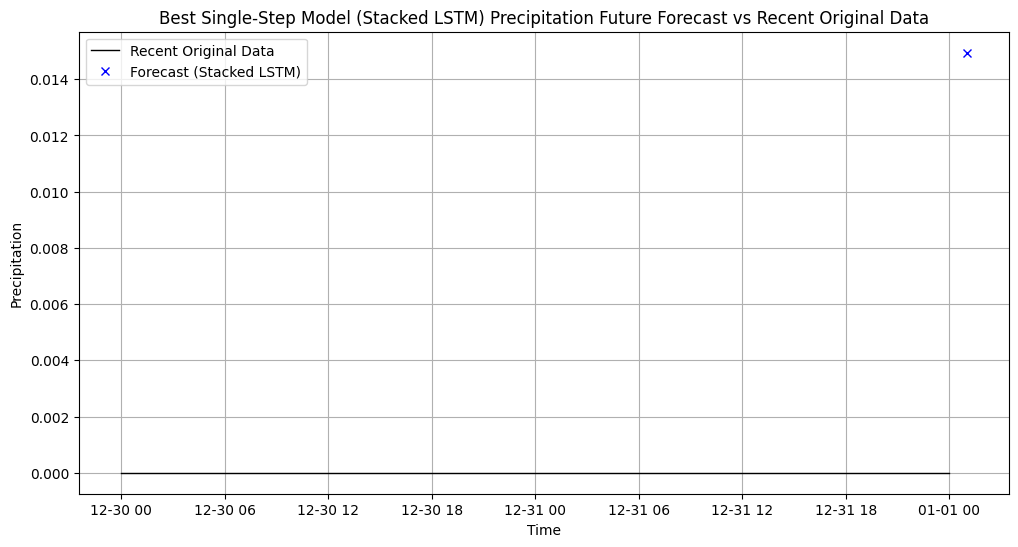

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # Import r2_score
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
import pickle
import pandas as pd # Import pandas for DataFrame and Timedelta
import seaborn as sns

# Ensure features is defined and contains the correct list of features for precipitation
if 'features' not in locals():
     features = ['Precipitation'] + [f'Precipitation_lag_{lag}' for lag in [1, 2, 3, 6, 12, 24, 48, 72]] + \
                     ['Precipitation_rolling_mean', 'Precipitation_rolling_std', 'hour', 'dayofweek', 'dayofyear', 'month', 'year']
     print("✅ 'features' list defined.")

# --- Load Saved Single-Step Models and Scalers ---

# Define the base path where the precipitation scalers were saved
vanilla_single_model_path = "/content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Precipitation Data Analysis and Forecasting/singlestep_model"
stacked_single_model_path = "/content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Precipitation Data Analysis and Forecasting/singlestep_model"
bidirectional_single_model_path = "/content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Precipitation Data Analysis and Forecasting/singlestep_model"


model_vanilla_single_file = os.path.join(vanilla_single_model_path, 'lstm_model_vanilla_single_pcp.h5')
scaler_vanilla_single_file = os.path.join(vanilla_single_model_path, 'scaler_vanilla_single_pcp_features.pkl')

model_stacked_single_file = os.path.join(stacked_single_model_path, 'lstm_model_stacked_single_pcp.h5')
scaler_stacked_single_file = os.path.join(stacked_single_model_path, 'scaler_stacked_single_pcp_features.pkl')

model_bidirectional_single_file = os.path.join(bidirectional_single_model_path, 'lstm_model_bidirectional_single_pcp.h5')
scaler_bidirectional_single_file = os.path.join(bidirectional_single_model_path, 'scaler_bidirectional_single_pcp_features.pkl')


# Load Vanilla Single-Step Model
model_vanilla_single_loaded = None
try:
    if os.path.exists(model_vanilla_single_file):
         model_vanilla_single_loaded = load_model(model_vanilla_single_file, custom_objects={'mse': MeanSquaredError()})
         print("✅ Vanilla Single-Step model loaded for comparison.")
    else:
         print(f"❌ Vanilla Single-Step model file not found at {model_vanilla_single_file}. Skipping.")
except Exception as e:
    print(f"Error loading Vanilla Single-Step model: {e}. Comparison might be incomplete.")
    model_vanilla_single_loaded = None


# Load Stacked Single-Step Model
model_stacked_single_loaded = None
try:
    if os.path.exists(model_stacked_single_file):
         model_stacked_single_loaded = load_model(model_stacked_single_file, custom_objects={'mse': MeanSquaredError()})
         print("✅ Stacked Single-Step model loaded for comparison.")
    else:
        print(f"❌ Stacked Single-Step model file not found at {model_stacked_single_file}. Skipping.")
except Exception as e:
    print(f"Error loading Stacked Single-Step model: {e}. Comparison might be incomplete.")
    model_stacked_single_loaded = None


# Load Bidirectional Single-Step Model
model_bidirectional_single_loaded = None
try:
    if os.path.exists(model_bidirectional_single_file):
        model_bidirectional_single_loaded = load_model(model_bidirectional_single_file, custom_objects={'mse': MeanSquaredError()})
        print("✅ Bidirectional Single-Step model loaded for comparison.")
    else:
        print(f"❌ Bidirectional Single-Step model file not found at {model_bidirectional_single_file}. Skipping.")
except Exception as e:
    print(f"Error loading Bidirectional Single-Step model: {e}. Comparison might be incomplete.")
    model_bidirectional_single_loaded = None


# Load Scaler (assuming all single-step models used the same scaler fitted on the same features)
scaler_single_loaded = None
# Try loading from any of the model paths as they should contain the same scaler
scaler_files_to_try = [scaler_vanilla_single_file, scaler_stacked_single_file, scaler_bidirectional_single_file]
for scaler_file in scaler_files_to_try:
    if os.path.exists(scaler_file):
         try:
              with open(scaler_file, 'rb') as f:
                 scaler_single_loaded = pickle.load(f)
              print(f"✅ Scaler loaded successfully from {scaler_file}.")
              break # Stop once a scaler is loaded
         except Exception as e:
              print(f"Error loading scaler from {scaler_file}: {e}")

if scaler_single_loaded is None:
     print("FATAL Error: Scaler could not be loaded for single-step evaluation. Cannot proceed.")
     # Exit the cell execution gracefully
     raise SystemExit("Scaler loading failed.")


# Ensure validation data is available (assuming X_val_single and y_val_single are in memory)
if 'X_val_single' not in locals() or 'y_val_single' not in locals() or 'df' not in locals() or df.empty or 'split_index_single' not in locals() or 'sequence_length' not in locals():
     print("FATAL Error: Required variables for single-step validation data or timestamps not found. Please run data preparation steps.")
     raise SystemExit("Single-step validation data or timestamps not found.")

# --- Inverse Transform True Values (only need to do this once) ---
# y_val_single contains scaled true values. Inverse transform them for metric calculation.
y_true_single_full = np.zeros((y_val_single.shape[0], len(features)))
y_true_single_full[:, 0] = y_val_single.flatten()
y_true_single_orig = scaler_single_loaded.inverse_transform(y_true_single_full)[:, 0]
print("✅ True single-step validation values inverse transformed for metric calculation.")

start_ts_index_val_single = split_index_single + sequence_length
end_ts_index_val_single = start_ts_index_val_single + len(y_val_single)

if end_ts_index_val_single <= len(df.index):
    val_timestamps_single = df.index[start_ts_index_val_single : end_ts_index_val_single].tolist()
    # Create a Series for the true values with the correct timestamps
    y_true_single_orig_series = pd.Series(y_true_single_orig, index=val_timestamps_single)
    print("✅ Single-step validation timestamps aligned.")
else:
    print(f"Error: Not enough timestamps in original df to match y_val_single. "
          f"Calculated end index {end_ts_index_val_single} exceeds df length {len(df.index)}.")
    val_timestamps_single = None
    y_true_single_orig_series = None


# --- Make Predictions and Collect Results for Comparison ---

predictions_single_orig = {} # Dictionary to store inverse transformed predictions for comparison

# Vanilla Single-Step LSTM Predictions
if model_vanilla_single_loaded is not None:
    y_pred_vanilla_single_scaled = model_vanilla_single_loaded.predict(X_val_single)
    y_pred_vanilla_single_orig_full = np.zeros((y_pred_vanilla_single_scaled.shape[0], len(features)))
    y_pred_vanilla_single_orig_full[:, 0] = y_pred_vanilla_single_scaled.flatten()
    predictions_single_orig['Vanilla LSTM'] = scaler_single_loaded.inverse_transform(y_pred_vanilla_single_orig_full)[:, 0]
    # Ensure precipitation predictions are non-negative
    predictions_single_orig['Vanilla LSTM'][predictions_single_orig['Vanilla LSTM'] < 0] = 0
    print("✅ Predictions made for Vanilla Single-Step LSTM.")

# Stacked Single-Step LSTM Predictions
if model_stacked_single_loaded is not None:
    y_pred_stacked_single_scaled = model_stacked_single_loaded.predict(X_val_single)
    y_pred_stacked_single_orig_full = np.zeros((y_pred_stacked_single_scaled.shape[0], len(features)))
    y_pred_stacked_single_orig_full[:, 0] = y_pred_stacked_single_scaled.flatten()
    predictions_single_orig['Stacked LSTM'] = scaler_single_loaded.inverse_transform(y_pred_stacked_single_orig_full)[:, 0]
     # Ensure precipitation predictions are non-negative
    predictions_single_orig['Stacked LSTM'][predictions_single_orig['Stacked LSTM'] < 0] = 0
    print("✅ Predictions made for Stacked Single-Step LSTM.")


# Bidirectional Single-Step LSTM Predictions
if model_bidirectional_single_loaded is not None:
    y_pred_bidirectional_single_scaled = model_bidirectional_single_loaded.predict(X_val_single)
    y_pred_bidirectional_single_orig_full = np.zeros((y_pred_bidirectional_single_scaled.shape[0], len(features)))
    y_pred_bidirectional_single_orig_full[:, 0] = y_pred_bidirectional_single_scaled.flatten()
    predictions_single_orig['Bidirectional LSTM'] = scaler_single_loaded.inverse_transform(y_pred_bidirectional_single_orig_full)[:, 0]
     # Ensure precipitation predictions are non-negative
    predictions_single_orig['Bidirectional LSTM'][predictions_single_orig['Bidirectional LSTM'] < 0] = 0
    print("✅ Predictions made for Bidirectional Single-Step LSTM.")


# --- Calculate and Compare Metrics ---

metrics_single = {} # Dictionary to store MAE and RMSE for each single-step model
best_single_model_name = None
min_single_rmse = float('inf')

if y_true_single_orig is not None:
    for model_name, y_pred_orig in predictions_single_orig.items():
        mae = mean_absolute_error(y_true_single_orig, y_pred_orig)
        rmse = np.sqrt(mean_squared_error(y_true_single_orig, y_pred_orig))
        r2 = r2_score(y_true_single_orig, y_pred_orig) # Calculate R2 score
        metrics_single[model_name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2} # Add R2 to metrics
        print(f"\n{model_name} Evaluation:")
        print(f"  MAE: {mae:.4f}")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  R2: {r2:.4f}") # Print R2 score

        # Determine the best single-step model based on RMSE
        if rmse < min_single_rmse:
            min_single_rmse = rmse
            best_single_model_name = model_name

else:
    print("\nSkipping single-step metric calculation as true values are not available.")


# --- Visualize Overall Performance Comparison ---

if metrics_single: # Only plot if metrics were calculated
    model_names = list(metrics_single.keys())
    mae_values = [metrics_single[name]['MAE'] for name in model_names]
    rmse_values = [metrics_single[name]['RMSE'] for name in model_names]
    r2_values = [metrics_single[name]['R2'] for name in model_names]

    x = np.arange(len(model_names)) # the label locations
    width = 0.35 # the width of the bars

    # Plot MAE and RMSE
    fig1, ax1 = plt.subplots(figsize=(12, 6))
    rects1 = ax1.bar(x - width/2, mae_values, width, label='MAE')
    rects2 = ax1.bar(x + width/2, rmse_values, width, label='RMSE')

    ax1.set_ylabel('Metric Value')
    ax1.set_title('Single-Step LSTM Model Performance Comparison (MAE and RMSE)')
    ax1.set_xticks(x)
    ax1.set_xticklabels(model_names)
    ax1.legend()

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax1.annotate('%.4f' % height,
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3), # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig1.tight_layout()
    plt.show()

    # Plot R2
    fig2, ax2 = plt.subplots(figsize=(12, 6))
    rects3 = ax2.bar(x, r2_values, width, label='R2', color='green')

    ax2.set_ylabel('R2 Score')
    ax2.set_title('Single-Step LSTM Model Performance Comparison (R2 Score)')
    ax2.set_xticks(x)
    ax2.set_xticklabels(model_names)
    ax2.legend()
    ax2.set_ylim(0, 1) # R2 score is typically between 0 and 1

    def autolabel_r2(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax2.annotate('%.4f' % height,
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3), # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel_r2(rects3)

    fig2.tight_layout()
    plt.show()


else:
     print("\nSkipping single-step performance comparison visualization as no metrics were available.")


print()

# --- Add Plot for Stacked LSTM Predictions on Validation Data (First 200 points) ---
# Explicitly use 'Stacked LSTM' for these plots
if 'Stacked LSTM' in predictions_single_orig and y_true_single_orig is not None:
    print(f"\n--- Best Single-Step Model (Stacked LSTM) Predictions on Validation Data (First 200 points) ---")
    plt.figure(figsize=(15, 7))
    plt.plot(y_true_single_orig[:200], label='True Precipitation', color='black', linewidth=2)

    # Get the predictions for the Stacked LSTM model
    y_pred_stacked_single_orig = predictions_single_orig['Stacked LSTM']

    plt.plot(y_pred_stacked_single_orig[:200], label=f'Predicted (Stacked LSTM)', color='blue', linestyle='--')

    plt.title(f'Best Single-Step Model (Stacked LSTM) Precipitation Predictions on Validation Data (First 200 points)')
    plt.xlabel('Time Step')
    plt.ylabel('Precipitation')
    plt.legend() # Added legend call
    plt.grid(True)
    plt.show()
else:
    print("\nSkipping Stacked LSTM predictions visualization on validation data (First 200 points) as data or model not available.")


# --- Add Plot for Stacked LSTM Predictions on Validation Data (Full Validation Set) ---
# Explicitly use 'Stacked LSTM' for these plots
if 'Stacked LSTM' in predictions_single_orig and y_true_single_orig_series is not None:
    print(f"\n--- Best Single-Step Model (Stacked LSTM) Predictions on Validation Data (Full Validation Set) ---")
    plt.figure(figsize=(20, 8))
    plt.plot(y_true_single_orig_series, label='True Precipitation', color='black', linewidth=1)

    # Get the predictions for the Stacked LSTM model
    y_pred_stacked_single_orig = predictions_single_orig['Stacked LSTM']
    y_pred_stacked_single_orig_series = pd.Series(y_pred_stacked_single_orig, index=y_true_single_orig_series.index)

    plt.plot(y_pred_stacked_single_orig_series, label=f'Predicted (Stacked LSTM)', color='blue', linestyle='--', alpha=0.7)

    plt.title(f'Best Single-Step Model (Stacked LSTM) Precipitation Predictions on Validation Data (Full Validation Set)')
    plt.xlabel('Time')
    plt.ylabel('Precipitation')
    plt.legend() # Added legend call
    plt.grid(True)
    plt.show()
else:
    print("\nSkipping Stacked LSTM predictions visualization on validation data (Full Validation Set) as data or model not available.")


# --- Add Scatter Plot: Predicted vs Observed (Single-Step Models) ---
if y_true_single_orig is not None and predictions_single_orig:
    print("\n--- Scatter Plot: Predicted vs Observed (Single-Step Models) ---")
    for model_name, y_pred_orig in predictions_single_orig.items():
        try:
            # Ensure y_true and y_pred have the same shape
            if y_true_single_orig.shape == y_pred_orig.shape:
                r2 = r2_score(y_true_single_orig, y_pred_orig)

                plt.figure(figsize=(6, 6))
                plt.scatter(y_true_single_orig, y_pred_orig, alpha=0.5, color='blue', edgecolors='k', label=f'{model_name} Predictions') # Added label for scatter points
                # Plotting the ideal fit line (y=x)
                min_val = min(y_true_single_orig.min(), y_pred_orig.min()) if y_true_single_orig.size > 0 and y_pred_orig.size > 0 else 0
                max_val = max(y_true_single_orig.max(), y_pred_orig.max()) if y_true_single_orig.size > 0 and y_pred_orig.size > 0 else 1
                plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Fit (True = Predicted)') # Added label for ideal fit line

                plt.xlabel("Observed Precipitation")
                plt.ylabel("Predicted Precipitation")
                plt.title(f"Predicted vs Observed ({model_name} - Validation Set)")
                plt.legend() # Added legend call
                # Position R2 annotation relative to plot limits
                x_pos = min_val + (max_val - min_val) * 0.05 # 5% from left
                y_pos = max_val - (max_val - min_val) * 0.05 # 5% from top
                plt.text(x_pos, y_pos, f'R² = {r2:.4f}', fontsize=12)
                plt.grid(True)
                plt.tight_layout()
                plt.show()
            else:
                print(f"Skipping scatter plot for {model_name}: Shape mismatch between true ({y_true_single_orig.shape}) and predicted ({y_pred_orig.shape}) values.")
        except Exception as e:
            print(f"Error generating scatter plot for {model_name}: {e}")
else:
    print("\nSkipping scatter plot generation for single-step models as true values or predictions are not available.")


# --- Make Future Forecast with Stacked LSTM Model ---

print("\n--- Making Future Forecast with Stacked LSTM Model ---")

# Assuming df is your original DataFrame with engineered features, sorted by time.
# You need the last 'seq_len' data points from the DataFrame with engineered features.
if 'X_val_single' not in locals():
    print("Error: X_val_single not found. Cannot determine sequence length for single-step forecasting.")
    seq_len_single = None
else:
    seq_len_single = X_val_single.shape[1] # Input sequence length for all single-step models (should match training)


if seq_len_single is not None and 'df' in locals() and not df.empty:
    # Ensure the DataFrame is sorted by time
    df.sort_index(inplace=True)

    # Get the last sequence for forecasting input
    last_sequence_single = df[features].tail(seq_len_single)
    if last_sequence_single.isnull().any().any():
         print("Warning: NaNs found in the last sequence used for single-step forecasting.")

    # Scale the last sequence using the loaded single-step scaler
    if scaler_single_loaded is not None:
        last_sequence_single_scaled = scaler_single_loaded.transform(last_sequence_single)
        # Reshape for LSTM input (1 sample, time steps, features)
        X_forecast_single = last_sequence_single_scaled.reshape(1, seq_len_single, len(features))
        print(f"✅ Data prepared for future single-step forecasting. Input shape: {X_forecast_single.shape}")
    else:
        print("Error: Scaler not loaded for single-step forecasting. Cannot prepare data.")
        X_forecast_single = None

else:
    print("Error: DataFrame 'df' is not loaded or is empty, or sequence length for single-step is not defined. Please ensure data loading and preprocessing were successful.")
    X_forecast_single = None


# Collect loaded single-step models in a dictionary
models_to_forecast_single = {
    'Vanilla LSTM': model_vanilla_single_loaded,
    'Stacked LSTM': model_stacked_single_loaded,
    'Bidirectional LSTM': model_bidirectional_single_loaded
}


# Use the best single-step model for future forecast
if X_forecast_single is not None and scaler_single_loaded is not None and best_single_model_name is not None and best_single_model_name in models_to_forecast_single and models_to_forecast_single[best_single_model_name] is not None:
    last_timestamp = df.index[-1]
    next_timestamp = last_timestamp + pd.Timedelta(hours=1) # Timestamp for the next hour

    # Get the best single-step model
    best_single_model_loaded = models_to_forecast_single[best_single_model_name]

    # Make forecast with the best single-step model
    try:
        prediction_scaled = best_single_model_loaded.predict(X_forecast_single)

        # Inverse transform the prediction
        prediction_full = np.zeros((prediction_scaled.shape[0], len(features)))
        prediction_full[:, 0] = prediction_scaled.flatten()
        prediction_orig = scaler_single_loaded.inverse_transform(prediction_full)[:, 0]

        # Ensure precipitation predictions are non-negative
        prediction_orig[prediction_orig < 0] = 0

        best_single_forecast_value = prediction_orig[0]

        print(f"\nBest Single-Step Model ({best_single_model_name}) Forecast for {next_timestamp}: {best_single_forecast_value:.4f}")

        # Plot future forecast for the best single-step model vs recent original data
        plt.figure(figsize=(12, 6))
        # Plot a point for the last known data point from the original df
        # Plot a longer segment of recent original data preceding the forecast
        plot_start_timestamp = last_timestamp - pd.Timedelta(hours=seq_len_single + 24) # Plot some hours before the input sequence

        recent_original_data = df['Precipitation'].loc[plot_start_timestamp : last_timestamp]

        plt.plot(recent_original_data.index, recent_original_data.values, label='Recent Original Data', color='black', linewidth=1)
        plt.plot(next_timestamp, best_single_forecast_value, 'x', color='blue', label=f'Forecast ({best_single_model_name})') # Use 'x' marker for single point forecast

        plt.title(f'Best Single-Step Model ({best_single_model_name}) Precipitation Future Forecast vs Recent Original Data')
        plt.xlabel('Time')
        plt.ylabel('Precipitation')
        plt.legend() # Added legend call
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"Error making forecast with the best single-step model ({best_single_model_name}): {e}")


else:
     print("\nSkipping best single-step future forecast visualization due to data preparation, scaler loading issues, or best model not identified/loaded.")

## **Build Vanilla Multi-Step LSTM Model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Determine the input shape for the multi-step model
# X_train_multi has shape (samples, timesteps, features)
input_shape_multi = (X_train_multi.shape[1], X_train_multi.shape[2]) # (timesteps, features)

# Determine the output shape for the multi-step model
# y_train_multi has shape (samples, forecast_horizon)
output_shape_multi = y_train_multi.shape[1] # forecast_horizon

# Build the Vanilla LSTM model for multi-step forecasting
model_vanilla_multi = Sequential([
    # Single LSTM layer
    LSTM(50, input_shape=input_shape_multi, return_sequences=False), # 50 units, input shape, return_sequences=False for single output vector

    # Output layer for multi-step prediction
    Dense(output_shape_multi, activation='linear') # Number of units equals the forecast horizon
])

# Compile the model
model_vanilla_multi.compile(optimizer='adam', loss='mse') # Use Adam optimizer and Mean Squared Error loss

# Print the model summary
print("Vanilla Multi-Step LSTM Model Summary:")
model_vanilla_multi.summary()

Vanilla Multi-Step LSTM Model Summary:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 50)             │        13,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 24)             │         1,224 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,624 (57.12 KB)

 Trainable params: 14,624 (57.12 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/4
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 52s 19ms/step - loss: 2.8082e-04 - val_loss: 1.2966e-04
Epoch 2/4
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 81s 19ms/step - loss: 4.9905e-05 - val_loss: 1.2985e-04
Epoch 3/4
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 82s 19ms/step - loss: 4.7715e-05 - val_loss: 1.3216e-04
Epoch 4/4
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 85s 20ms/step - loss: 4.7449e-05 - val_loss: 1.2859e-04


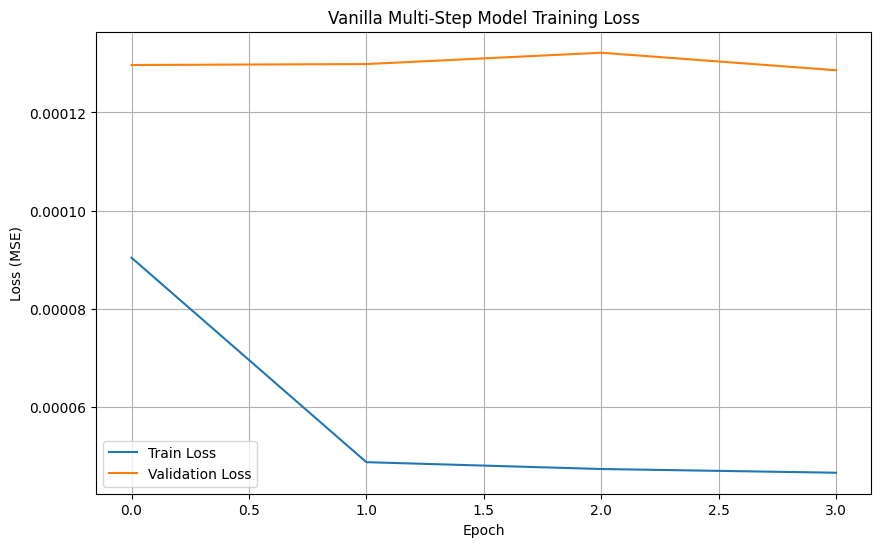

In [ ]:
# Train the model
history_vanilla_multi = model_vanilla_multi.fit(X_train_multi, y_train_multi,
                                                       epochs=4, # Using 10 epochs for consistency with previous single-step models
                                                       batch_size=64, # Using a batch size of 64
                                                       validation_data=(X_val_multi, y_val_multi)) # Use validation data to monitor performance

# Plot the training and validation loss over epochs.
plt.figure(figsize=(10, 6))
plt.plot(history_vanilla_multi.history['loss'], label='Train Loss')
plt.plot(history_vanilla_multi.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Vanilla Multi-Step Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.grid(True)
plt.show()

## **Save Vanilla Multi-Step Model and Scaler**

In [ ]:
import os
import pickle
from tensorflow.keras.models import save_model

# Define the path to save the multi-step models and scalers
multistep_model_path = "/content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Precipitation Data Analysis and Forecasting/multistep24_model"
os.makedirs(multistep_model_path, exist_ok=True)

# Define the path to save the Vanilla Multi-Step LSTM model and scaler.
model_vanilla_multi_file = os.path.join(multistep_model_path, 'lstm_model_vanilla_multi_pcp.h5') # Changed name to pcp
scaler_vanilla_multi_file = os.path.join(multistep_model_path, 'scaler_vanilla_multi_pcp_features.pkl') # Changed name to pcp

# Save the trained Vanilla Multi-Step LSTM model in .h5 format.
save_model(model_vanilla_multi, model_vanilla_multi_file)

# Save the fitted MinMaxScaler (assuming scaler_multi_step is the one used for normalization).
# Make sure 'scaler_multi_step' variable is available in the environment.
if 'scaler_pcp' in locals():
    with open(scaler_vanilla_multi_file, 'wb') as f:
        pickle.dump(scaler_pcp, f) # Use scaler_multi_step that was fitted earlier

    print("✅ Vanilla Multi-Step LSTM Precipitation Model and Scaler saved successfully.")
    print(f"Model saved at: {model_vanilla_multi_file}")
    print(f"Scaler saved at: {scaler_vanilla_multi_file}")
else:
    print("❌ Error: 'scaler_multi_step' variable not found. Cannot save scaler.")

✅ Vanilla Multi-Step LSTM Precipitation Model and Scaler saved successfully.
Model saved at: /content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Precipitation Data Analysis and Forecasting/multistep24_model/lstm_model_vanilla_multi_pcp.h5
Scaler saved at: /content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Precipitation Data Analysis and Forecasting/multistep24_model/scaler_vanilla_multi_pcp_features.pkl


## **Build Stacked Multi-Step LSTM Model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Determine the input shape for the multi-step model
# X_train_multi has shape (samples, timesteps, features)
input_shape_multi = (X_train_multi.shape[1], X_train_multi.shape[2]) # (timesteps, features)

# Determine the output shape for the multi-step model
# y_train_multi has shape (samples, forecast_horizon)
output_shape_multi = y_train_multi.shape[1] # forecast_horizon

# Build the Stacked LSTM model for multi-step forecasting
model_stacked_multi = Sequential([
    # First LSTM layer (return_sequences=True to stack another LSTM layer)
    LSTM(50, input_shape=input_shape_multi, return_sequences=True), # 50 units, input shape, returns sequences

    # Second LSTM layer
    LSTM(50, return_sequences=False), # 50 units, does not return sequences

    # Output layer for multi-step prediction
    Dense(output_shape_multi, activation='linear') # Number of units equals the forecast horizon (using linear for precipitation)
])

# Compile the model
model_stacked_multi.compile(optimizer='adam', loss='mse') # Use Adam optimizer and Mean Squared Error loss

# Print the model summary
print("Stacked Multi-Step LSTM Model Summary:")
model_stacked_multi.summary()

Stacked Multi-Step LSTM Model Summary:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 24, 50)         │        13,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 24)             │         1,224 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,824 (136.03 KB)

 Trainable params: 34,824 (136.03 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 112s 41ms/step - loss: 1.5942e-04 - val_loss: 1.3109e-04
Epoch 2/8
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 141s 40ms/step - loss: 4.9871e-05 - val_loss: 1.2999e-04
Epoch 3/8
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 145s 42ms/step - loss: 4.8660e-05 - val_loss: 1.2911e-04
Epoch 4/8
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 103s 40ms/step - loss: 4.6913e-05 - val_loss: 1.3090e-04
Epoch 5/8
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 106s 41ms/step - loss: 4.4393e-05 - val_loss: 1.3074e-04
Epoch 6/8
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 142s 41ms/step - loss: 4.5821e-05 - val_loss: 1.2796e-04
Epoch 7/8
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 141s 40ms/step - loss: 4.5210e-05 - val_loss: 1.2956e-04
Epoch 8/8
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 102s 39ms/step - loss: 4.4464e-05 - val_loss: 1.2737e-04


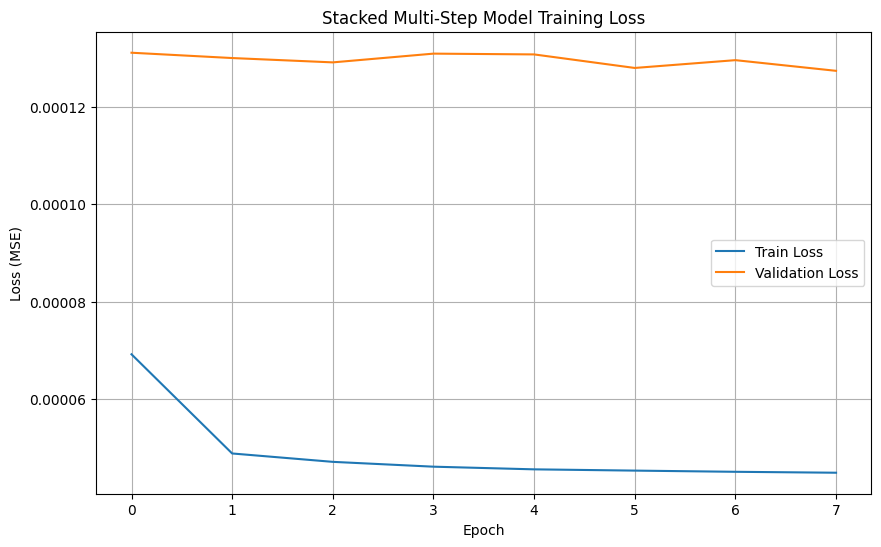

In [ ]:
# Train the model
history_stacked_multi = model_stacked_multi.fit(X_train_multi, y_train_multi,
                                                         epochs=8, # Using 10 epochs for consistency
                                                         batch_size=64, # Using a batch size of 128
                                                         validation_data=(X_val_multi, y_val_multi)) # Use validation data to monitor performance

# Plot the training and validation loss over epochs.
plt.figure(figsize=(10, 6))
plt.plot(history_stacked_multi.history['loss'], label='Train Loss')
plt.plot(history_stacked_multi.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Stacked Multi-Step Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.grid(True)
plt.show()

## **Save Stacked Multi-Step Model and Scaler**

In [ ]:
import os
import pickle
from tensorflow.keras.models import save_model

# Define the path to save the multi-step models and scalers
multistep_model_path = "/content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Precipitation Data Analysis and Forecasting/multistep24_model"
os.makedirs(multistep_model_path, exist_ok=True)

# Define the path to save the Stacked Multi-Step LSTM model and scaler.
model_stacked_multi_file = os.path.join(multistep_model_path, 'lstm_model_stacked_multi_pcp.h5') # Changed name to pcp
scaler_stacked_multi_file = os.path.join(multistep_model_path, 'scaler_stacked_multi_pcp_features.pkl') # Changed name to pcp

# Save the trained Stacked Multi-Step LSTM model in .h5 format.
save_model(model_stacked_multi, model_stacked_multi_file)

# Save the fitted MinMaxScaler (assuming scaler_multi_step is the one used for normalization).
# Make sure 'scaler_multi_step' variable is available in the environment.
if 'scaler_pcp' in locals():
    with open(scaler_stacked_multi_file, 'wb') as f:
        pickle.dump(scaler_pcp, f) # Use scaler_multi_step that was fitted earlier

    print("✅ Stacked Multi-Step LSTM Precipitation Model and Scaler saved successfully.")
    print(f"Model saved at: {model_stacked_multi_file}")
    print(f"Scaler saved at: {scaler_stacked_multi_file}")
else:
    print("❌ Error: 'scaler_multi_step' variable not found. Cannot save scaler.")

✅ Stacked Multi-Step LSTM Precipitation Model and Scaler saved successfully.
Model saved at: /content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Precipitation Data Analysis and Forecasting/multistep24_model/lstm_model_stacked_multi_pcp.h5
Scaler saved at: /content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Precipitation Data Analysis and Forecasting/multistep24_model/scaler_stacked_multi_pcp_features.pkl


## **Build Bidirectional Multi-Step LSTM Model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
import matplotlib.pyplot as plt

# Determine the input shape for the multi-step model
# X_train_multi has shape (samples, timesteps, features)
input_shape_multi = (X_train_multi.shape[1], X_train_multi.shape[2]) # (timesteps, features)

# Determine the output shape for the multi-step model
# y_train_multi has shape (samples, forecast_horizon)
output_shape_multi = y_train_multi.shape[1] # forecast_horizon

# Build the Bidirectional LSTM model for multi-step forecasting
model_bidirectional_multi = Sequential([
    # Bidirectional LSTM layer wrapping an LSTM layer
    Bidirectional(LSTM(50, return_sequences=False), # 50 LSTM units, return_sequences=False for single output vector
                  input_shape=input_shape_multi), # Define input shape

    # Output layer for multi-step prediction
    Dense(output_shape_multi, activation='linear') # Number of units equals the forecast horizon
])

# Compile the model
model_bidirectional_multi.compile(optimizer='adam', loss='mse') # Use Adam optimizer and Mean Squared Error loss

# Print the model summary
print("Bidirectional Multi-Step LSTM Model Summary:")
model_bidirectional_multi.summary()

Bidirectional Multi-Step LSTM Model Summary:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 100)            │        26,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 24)             │         2,424 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,224 (114.16 KB)

 Trainable params: 29,224 (114.16 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 87s 32ms/step - loss: 3.4959e-04 - val_loss: 1.3056e-04
Epoch 2/6
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 145s 33ms/step - loss: 4.9370e-05 - val_loss: 1.3093e-04
Epoch 3/6
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 142s 33ms/step - loss: 4.9097e-05 - val_loss: 1.3308e-04
Epoch 4/6
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 83s 32ms/step - loss: 4.6476e-05 - val_loss: 1.2968e-04
Epoch 5/6
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 146s 33ms/step - loss: 4.5973e-05 - val_loss: 1.3042e-04
Epoch 6/6
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 140s 33ms/step - loss: 4.6676e-05 - val_loss: 1.2907e-04


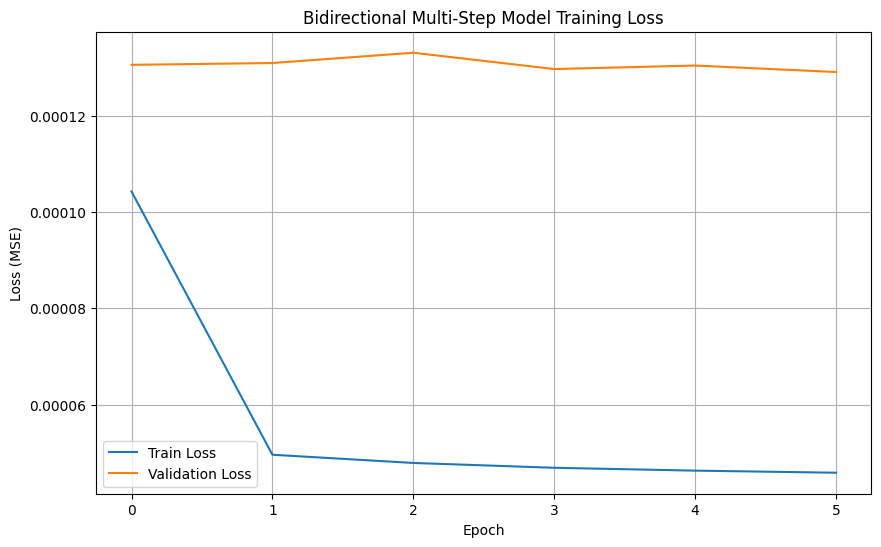

In [ ]:
# Train the model
history_bidirectional_multi = model_bidirectional_multi.fit(X_train_multi, y_train_multi,
                                                                    epochs=6, # Using 10 epochs for consistency
                                                                    batch_size=64, # Using a batch size of 64
                                                                    validation_data=(X_val_multi, y_val_multi)) # Use validation data to monitor performance

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history_bidirectional_multi.history['loss'], label='Train Loss')
plt.plot(history_bidirectional_multi.history['val_loss'], label='Validation Loss')
plt.title('Bidirectional Multi-Step Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

## **Save Bidirectional Multi-Step Model and Scaler**

In [ ]:
import os
import pickle
from tensorflow.keras.models import save_model

# Define the path to save the multi-step models and scalers
multistep_model_path = "/content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Precipitation Data Analysis and Forecasting/multistep24_model"
os.makedirs(multistep_model_path, exist_ok=True)

# Define the path to save the Bidirectional Multi-Step LSTM model and scaler.
model_bidirectional_multi_file = os.path.join(multistep_model_path, 'lstm_model_bidirectional_multi_pcp.h5') # Changed name to pcp
scaler_bidirectional_multi_file = os.path.join(multistep_model_path, 'scaler_bidirectional_multi_pcp_features.pkl') # Changed name to pcp

# Save the trained Bidirectional Multi-Step LSTM model in .h5 format.
save_model(model_bidirectional_multi, model_bidirectional_multi_file)

# Save the fitted MinMaxScaler (assuming scaler_pcp is the one used for normalization).
# Make sure 'scaler_pcp' variable is available in the environment.
if 'scaler_pcp' in locals():
    with open(scaler_bidirectional_multi_file, 'wb') as f:
        pickle.dump(scaler_pcp, f) # Use scaler_pcp that was fitted earlier

    print("✅ Bidirectional Multi-Step LSTM Precipitation Model and Scaler saved successfully.")
    print(f"Model saved at: {model_bidirectional_multi_file}")
    print(f"Scaler saved at: {scaler_bidirectional_multi_file}") # Corrected variable name
else:
    print("❌ Error: 'scaler_pcp' variable not found. Cannot save scaler.")

## **Evaluate and Compare Multi-Step LSTM Models**

✅ Vanilla Multi-Step model loaded successfully from /content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Precipitation Data Analysis and Forecasting/multistep24_model/lstm_model_vanilla_multi_pcp.h5
✅ Vanilla Multi-Step scaler loaded successfully from /content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Precipitation Data Analysis and Forecasting/model/scaler_pcp_features.pkl
✅ Stacked Multi-Step model loaded successfully from /content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Precipitation Data Analysis and Forecasting/multistep24_model/lstm_model_stacked_multi_pcp.h5
✅ Stacked Multi-Step scaler loaded successfully from /content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Precipitation Data Analysis and Forecasting/model/scaler_pcp_features.pkl
✅ Bidirectional Multi-Step model loaded successfully from /content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Precipitation Da

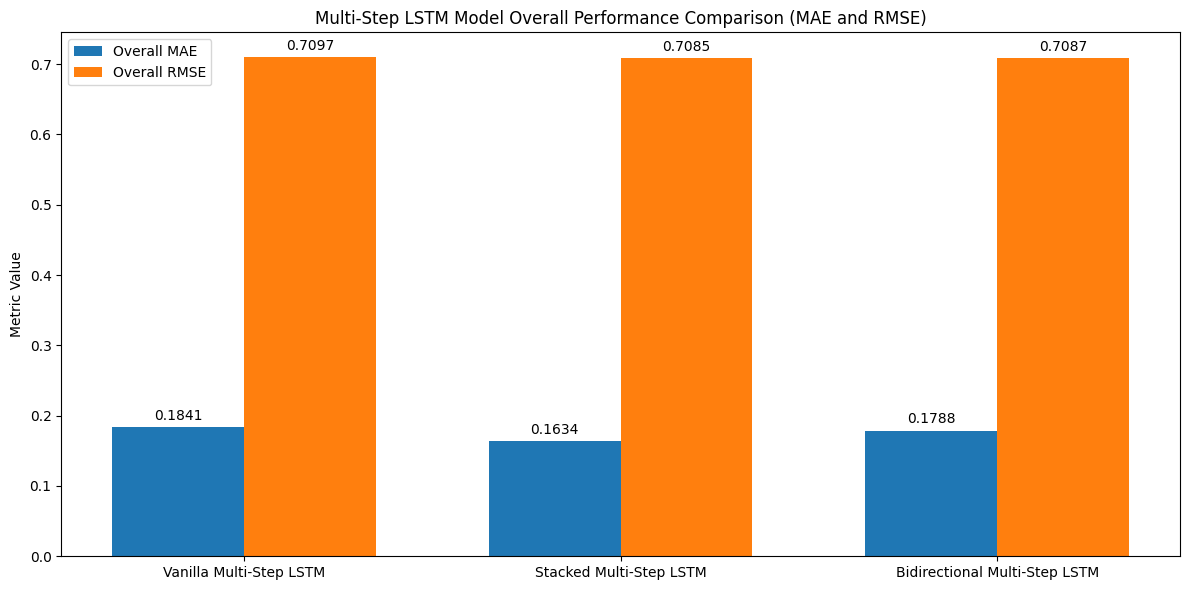

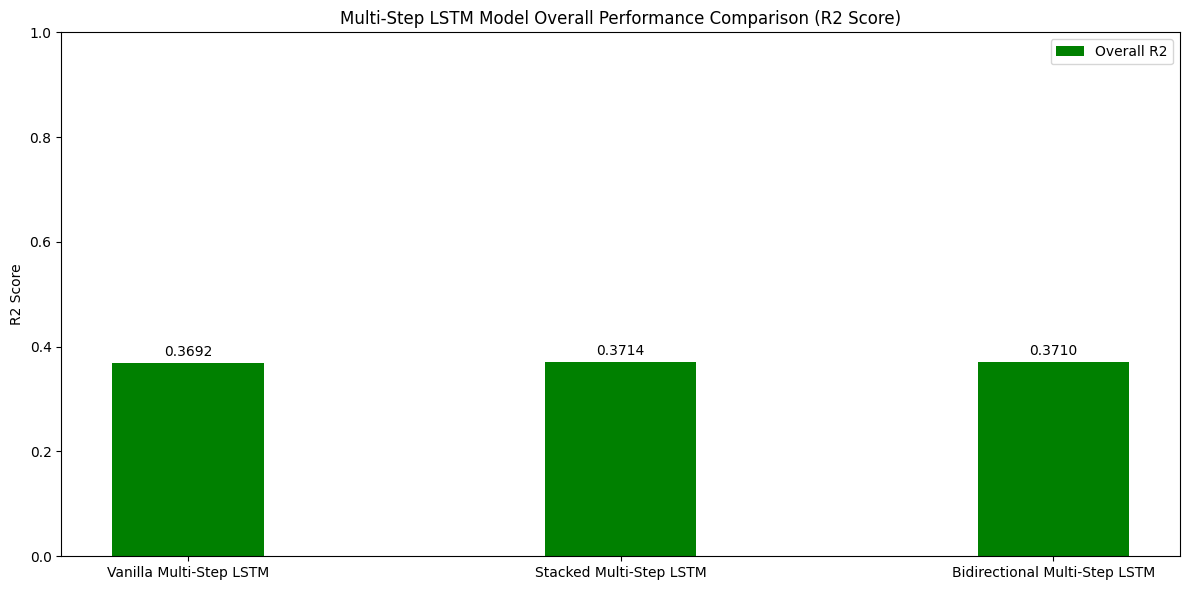

/tmp/ipython-input-14-2542200447.py:297: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(steps, rmse_values, styles[i % len(styles)], label=f'{model_name} RMSE', linestyle='--', color=f'C{i}')
/tmp/ipython-input-14-2542200447.py:297: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "s-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(steps, rmse_values, styles[i % len(styles)], label=f'{model_name} RMSE', linestyle='--', color=f'C{i}')
/tmp/ipython-input-14-2542200447.py:297: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "x-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(steps, rmse_values, styles[i % len(styles)], label=f'{model_name} RMSE', linestyle='--', color=f'C{i}')


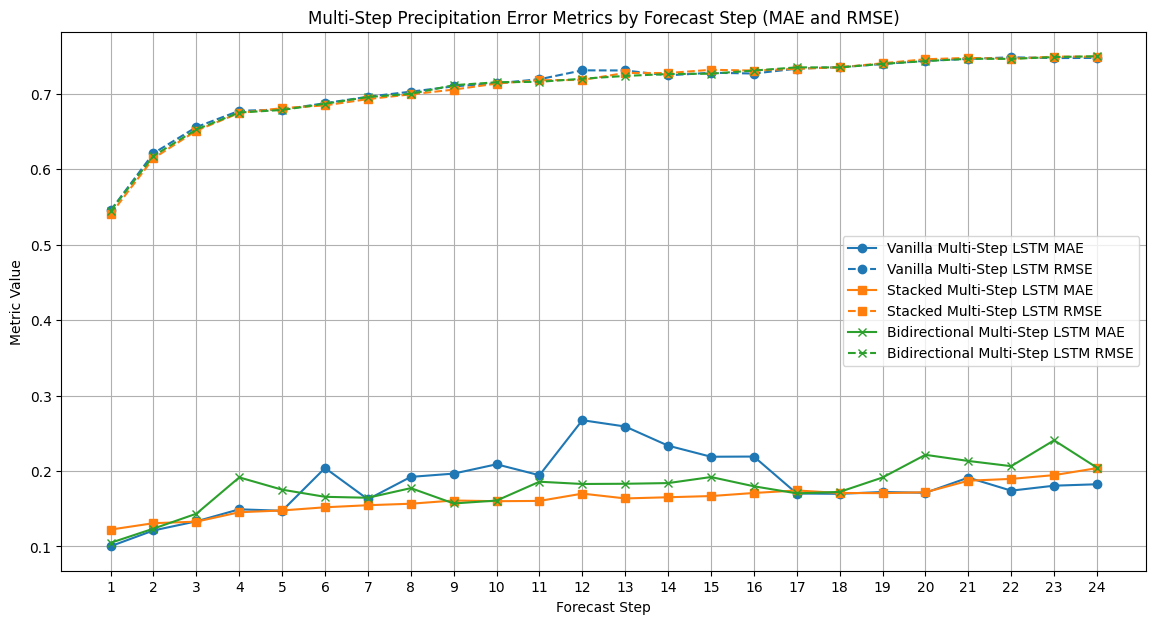

/tmp/ipython-input-14-2542200447.py:312: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(steps, r2_values, styles[i % len(styles)], label=f'{model_name} R2', linestyle=':', color=f'C{i}') # Add R2 plot
/tmp/ipython-input-14-2542200447.py:312: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "s-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(steps, r2_values, styles[i % len(styles)], label=f'{model_name} R2', linestyle=':', color=f'C{i}') # Add R2 plot
/tmp/ipython-input-14-2542200447.py:312: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "x-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(steps, r2_values, styles[i % len(styles)], label=f'{model_name} R2', linestyle=':', color=f'C{i}') # Add R2 plo

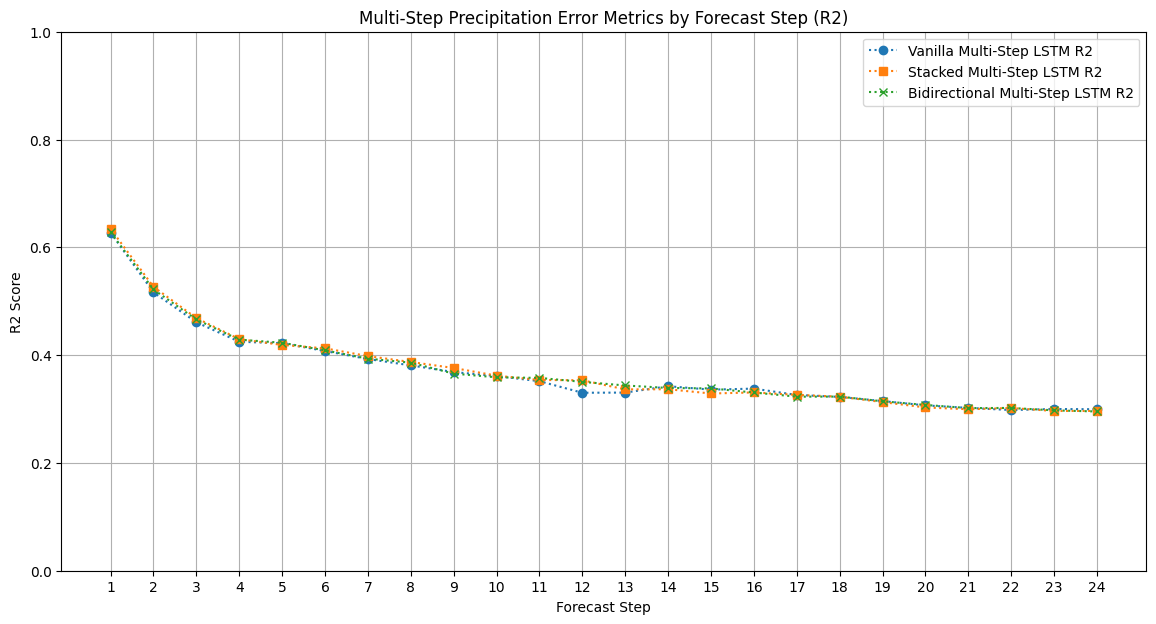



--- Scatter Plot: Predicted vs Observed (Multi-Step Models - Step +1) ---


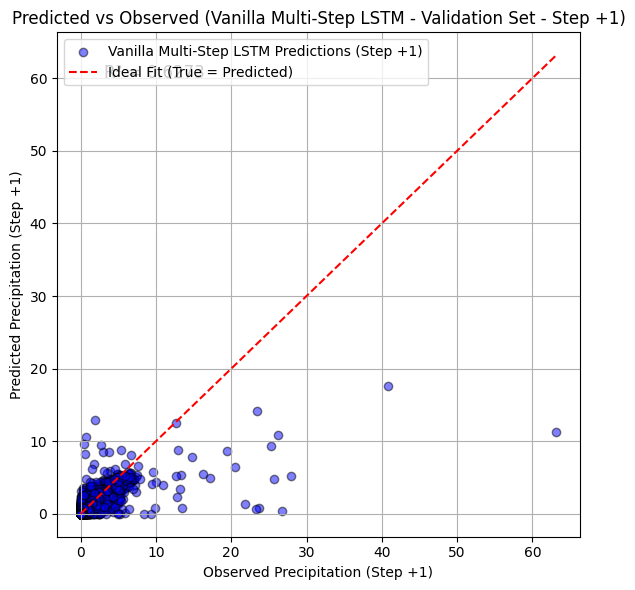

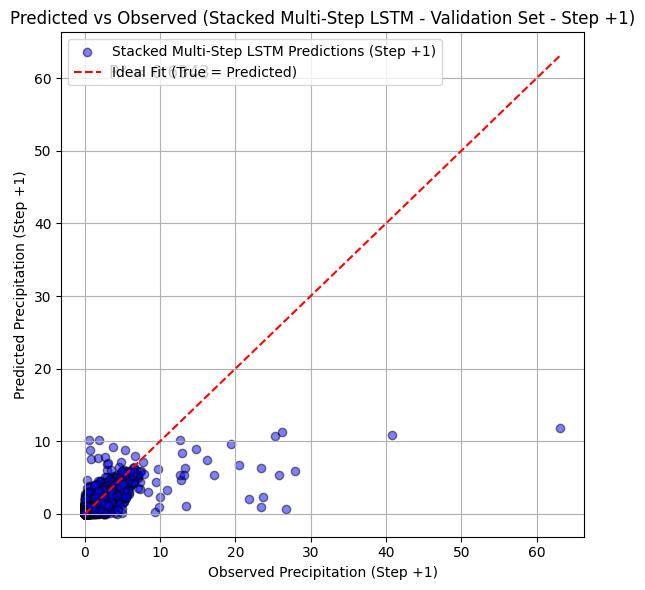

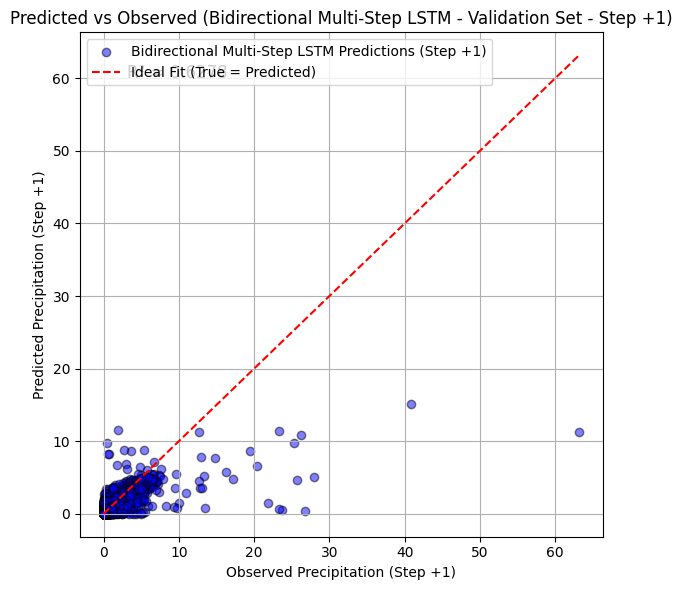


--- Best Multi-Step Model (Stacked Multi-Step LSTM) Predictions on Validation Data (First 200 points - Step +1) ---


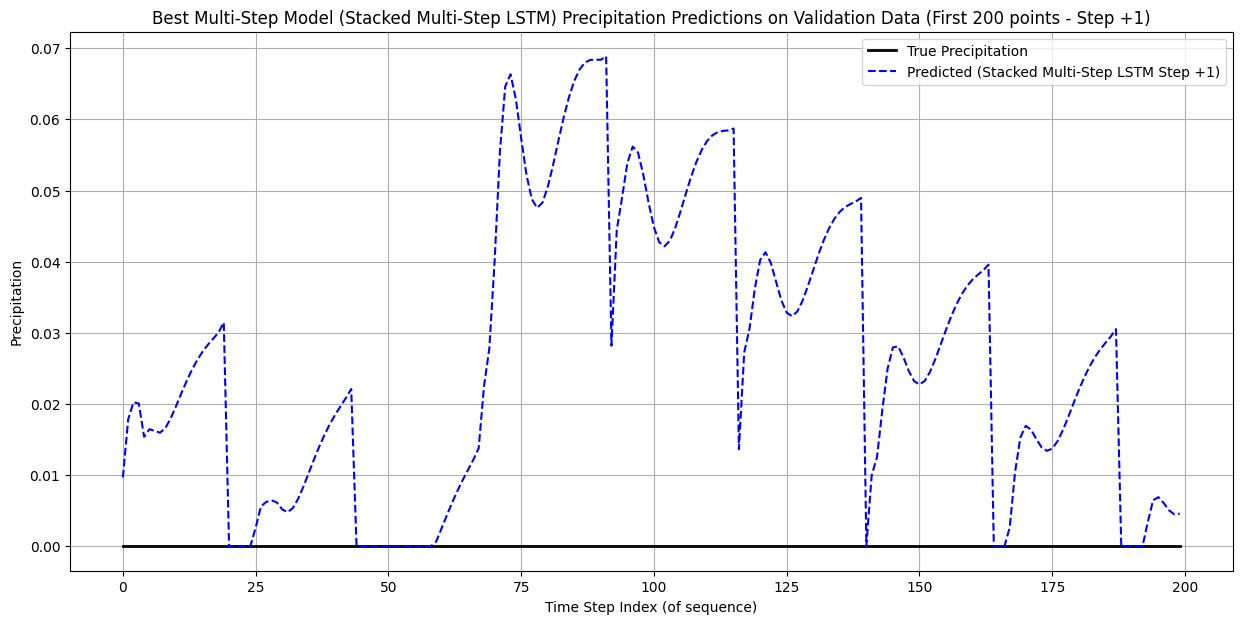



--- Best Multi-Step Model (Stacked Multi-Step LSTM) Predictions on Validation Data (Full Validation Set - Step +1) ---


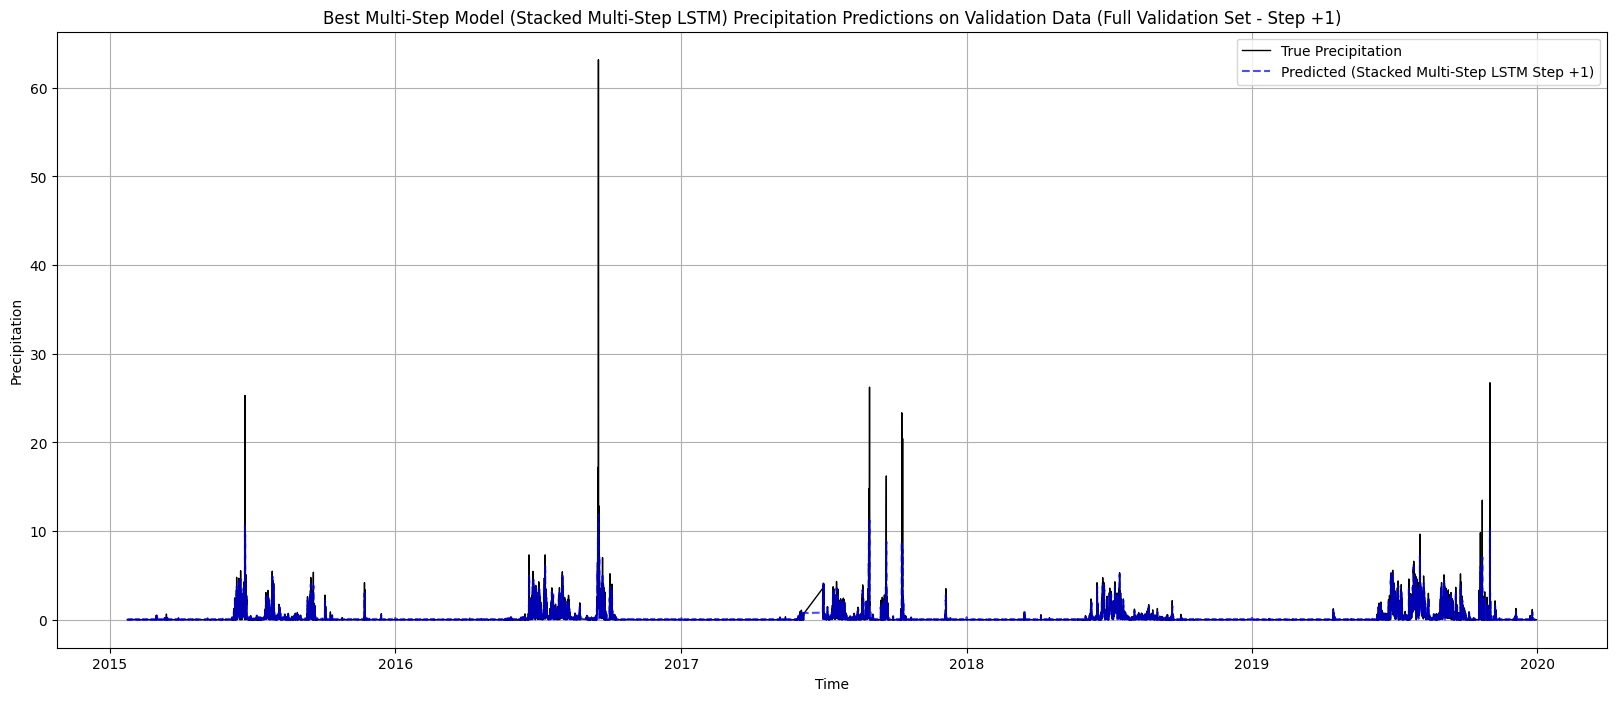


--- Making Future Multi-Step Forecasts ---
✅ Data prepared for future multi-step forecasting. Input shape: (1, 24, 16)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step

Best Multi-Step Model (Stacked Multi-Step LSTM) Multi-Step Forecast:
  2020-01-01 01:00:00: 0.1343
  2020-01-01 02:00:00: 0.0874
  2020-01-01 03:00:00: 0.0212
  2020-01-01 04:00:00: 0.0000
  2020-01-01 05:00:00: 0.0000
  2020-01-01 06:00:00: 0.0000
  2020-01-01 07:00:00: 0.0011
  2020-01-01 08:00:00: 0.0000
  2020-01-01 09:00:00: 0.0091
  2020-01-01 10:00:00: 0.0000
  2020-01-01 11:00:00: 0.0000
  2020-01-01 12:00:00: 0.0000
  2020-01-01 13:00:00: 0.0000
  2020-01-01 14:00:00: 0.0000
  2020-01-01 15:00:00: 0.0000
  2020-01-01 16:00:00: 0.0000
  2020-01-01 17:00:00: 0.0000
  2020-01-01 18:00:00: 0.0000
  2020-01-01 19:00:00: 0.0000
  2020-01-01 20:00:00: 0.0000
  2020-01-01 21:00:00: 0.0000
  2020-01-01 22:00:00: 0.0105
  2020-01-01 23:00:00: 0.0022
  2020-01-02 00:00:00: 0.0371


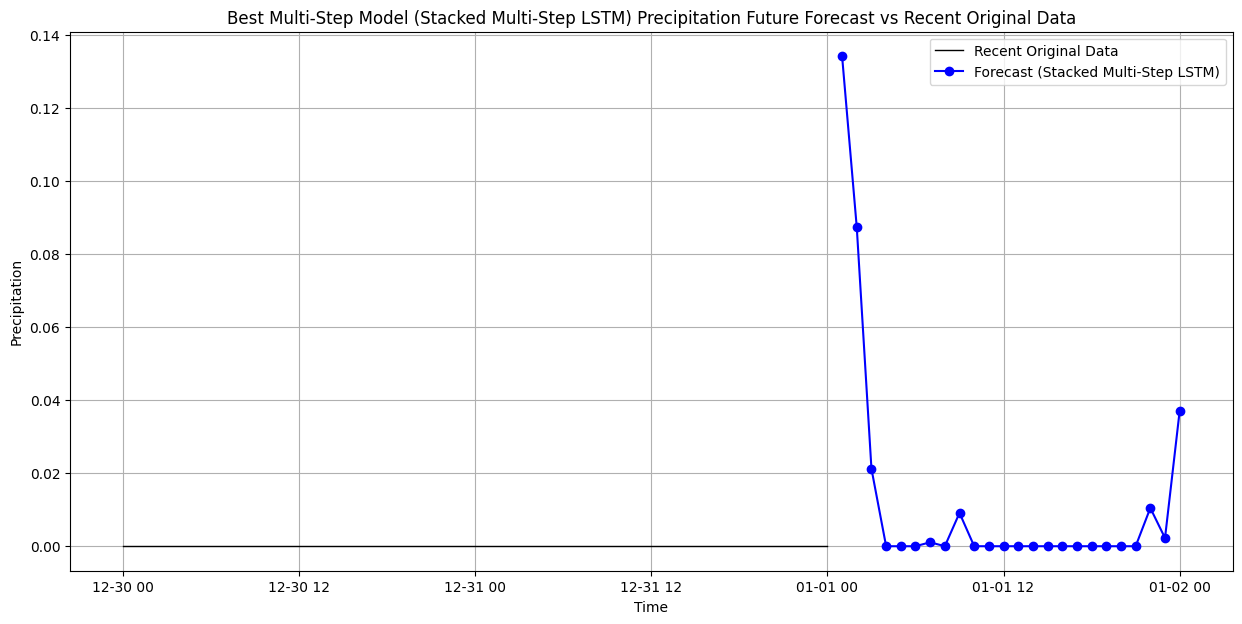

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # Import r2_score
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
import pickle
import pandas as pd
import seaborn as sns

# Ensure features is defined (assuming it was defined during precipitation data preparation)
if 'features' not in locals():
     features = ['Precipitation'] + [f'Precipitation_lag_{lag}' for lag in [1, 2, 3, 6, 12, 24, 48, 72]] + \
                     ['Precipitation_rolling_mean', 'Precipitation_rolling_std', 'hour', 'dayofweek', 'dayofyear', 'month', 'year']
     print("✅ 'features' list defined.")


# --- Load Multi-Step Models and Scalers ---

models_multi_loaded = {} # Dictionary to store loaded multi-step models
scalers_multi_loaded = {} # Dictionary to store loaded multi-step scalers (though they should be the same)

# Define the base path where the precipitation scalers were saved
multistep_model_path = "/content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Precipitation Data Analysis and Forecasting/multistep24_model"

# Define the file paths for models and scalers
model_vanilla_multi_file = os.path.join(multistep_model_path, 'lstm_model_vanilla_multi_pcp.h5') # Changed name to pcp
scaler_vanilla_multi_file = os.path.join(multistep_model_path, 'scaler_vanilla_multi_pcp_features.pkl') # Changed name to pcp

model_stacked_multi_file = os.path.join(multistep_model_path, 'lstm_model_stacked_multi_pcp.h5') # Changed name to pcp
scaler_stacked_multi_file = os.path.join(multistep_model_path, 'scaler_stacked_multi_pcp_features.pkl') # Changed name to pcp

model_bidirectional_multi_file = os.path.join(multistep_model_path, 'lstm_model_bidirectional_multi_pcp.h5') # Changed name to pcp
scaler_bidirectional_multi_file = os.path.join(multistep_model_path, 'scaler_bidirectional_multi_pcp_features.pkl') # Changed name to pcp


# Load Vanilla Multi-Step Model
try:
    # Check if the model file exists before attempting to load
    if os.path.exists(model_vanilla_multi_file):
        models_multi_loaded['Vanilla Multi-Step LSTM'] = load_model(model_vanilla_multi_file, custom_objects={'mse': MeanSquaredError()})
        print(f"✅ Vanilla Multi-Step model loaded successfully from {model_vanilla_multi_file}")
    else:
        print(f"❌ Vanilla Multi-Step model file not found at {model_vanilla_multi_file}")

    # Check if the scaler file exists before attempting to load
    # Assuming the scaler was saved with the name 'scaler_pcp_features.pkl' during data preparation
    scaler_pcp_file_path_from_prep = os.path.join("/content/drive/MyDrive/Colab Notebooks/Time Series Analysis and Forecasting/Precipitation Data Analysis and Forecasting/model", 'scaler_pcp_features.pkl') # Path from Data Normalization step
    if os.path.exists(scaler_pcp_file_path_from_prep):
        with open(scaler_pcp_file_path_from_prep, 'rb') as f:
             scalers_multi_loaded['Vanilla Multi-Step LSTM'] = pickle.load(f)
        print(f"✅ Vanilla Multi-Step scaler loaded successfully from {scaler_pcp_file_path_from_prep}")
    else:
         print(f"❌ Vanilla Multi-Step scaler file not found at {scaler_pcp_file_path_from_prep}. Please ensure Data Normalization cell was run.")

except Exception as e:
    print(f"Error loading Vanilla Multi-Step model or scaler: {e}")

# Load Stacked Multi-Step Model and Scaler
try:
    # Check if the model file exists before attempting to load
    if os.path.exists(model_stacked_multi_file):
        models_multi_loaded['Stacked Multi-Step LSTM'] = load_model(model_stacked_multi_file, custom_objects={'mse': MeanSquaredError()})
        print(f"✅ Stacked Multi-Step model loaded successfully from {model_stacked_multi_file}")
    else:
        print(f"❌ Stacked Multi-Step model file not found at {model_stacked_multi_file}")

    # Use the same logic to load the scaler, assuming it's saved in the same place
    if os.path.exists(scaler_pcp_file_path_from_prep):
        with open(scaler_pcp_file_path_from_prep, 'rb') as f:
             scalers_multi_loaded['Stacked Multi-Step LSTM'] = pickle.load(f)
        print(f"✅ Stacked Multi-Step scaler loaded successfully from {scaler_pcp_file_path_from_prep}")
    else:
        print(f"❌ Stacked Multi-Step scaler file not found at {scaler_pcp_file_path_from_prep}. Please ensure Data Normalization cell was run.")

except Exception as e:
    print(f"Error loading Stacked Multi-Step model or scaler: {e}")

# Load Bidirectional Multi-Step Model and Scaler
try:
    # Check if the model file exists before attempting to load
    if os.path.exists(model_bidirectional_multi_file):
        models_multi_loaded['Bidirectional Multi-Step LSTM'] = load_model(model_bidirectional_multi_file, custom_objects={'mse': MeanSquaredError()})
        print(f"✅ Bidirectional Multi-Step model loaded successfully from {model_bidirectional_multi_file}")
    else:
        print(f"❌ Bidirectional Multi-Step model file not found at {model_bidirectional_multi_file}")

    # Use the same logic to load the scaler
    if os.path.exists(scaler_pcp_file_path_from_prep):
        with open(scaler_pcp_file_path_from_prep, 'rb') as f:
             scalers_multi_loaded['Bidirectional Multi-Step LSTM'] = pickle.load(f)
        print(f"✅ Bidirectional Multi-Step scaler loaded successfully from {scaler_pcp_file_path_from_prep}")
    else:
        print(f"❌ Bidirectional Multi-Step scaler file not found at {scaler_pcp_file_path_from_prep}. Please ensure Data Normalization cell was run.")

except Exception as e:
    print(f"Error loading Bidirectional Multi-Step model or scaler: {e}")


# Ensure validation data is available (assuming X_val_multi and y_val_multi are in memory from previous steps)
if 'X_val_multi' not in locals() or 'y_val_multi' not in locals() or 'df' not in locals() or df.empty or 'split_index_multi' not in locals() or 'inp_length' not in locals() or 'out_length' not in locals():
     print("FATAL Error: Required variables for multi-step validation data or timestamps not found. Please run data preparation steps.")
     raise SystemExit("Multi-step validation data or timestamps not found.")


# Ensure at least one model was loaded
if not models_multi_loaded:
     print("FATAL Error: No multi-step precipitation models were loaded successfully. Cannot proceed with evaluation.")
     raise SystemExit("No multi-step models loaded.")

# Assuming all scalers loaded are the same, use one for inverse transformation
# You might want to add a check here to ensure all loaded scalers are identical if necessary.
scaler_loaded_multi = list(scalers_multi_loaded.values())[0] if scalers_multi_loaded else None

if scaler_loaded_multi is None:
     print("FATAL Error: Scaler could not be loaded for multi-step evaluation. Cannot proceed.")
     raise SystemExit("Scaler for multi-step evaluation not loaded.")


# --- Inverse Transform True Values (only need to do this once) ---
# y_val_multi contains scaled true values. Inverse transform them for metric calculation.
dummy_true_array_temp = np.zeros((y_val_multi.shape[0] * y_val_multi.shape[1], len(features)))
dummy_true_array_temp[:, 0] = y_val_multi.flatten()
y_true_multi_temp_orig = scaler_loaded_multi.inverse_transform(dummy_true_array_temp)[:, 0].reshape(y_val_multi.shape)
print("✅ True multi-step validation values inverse transformed for metric calculation.")

# Create a list of timestamps for all predicted points in the validation set
all_predicted_timestamps_multi = []
for i in range(len(y_val_multi)):
    for j in range(out_length):
        # Ensure the calculated index is within the bounds of df.index
        timestamp_index = split_index_multi + i + inp_length + j
        if timestamp_index < len(df.index):
             all_predicted_timestamps_multi.append(df.index[timestamp_index])
        else:
             print(f"Warning: Calculated timestamp index {timestamp_index} exceeds df length {len(df.index)}. Stopping timestamp generation.")
             break # Stop adding timestamps if we go out of bounds
    if timestamp_index >= len(df.index):
         break # Stop processing sequences if we went out of bounds

# Create a pandas Index from the generated timestamps
true_multi_plotting_index = pd.Index(all_predicted_timestamps_multi)

# Reshape y_true_multi_temp_orig to match the flattened predictions for plotting
y_true_multi_orig_flat = y_true_multi_temp_orig.flatten()

# Ensure the flattened true values match the number of generated timestamps
if len(y_true_multi_orig_flat) == len(true_multi_plotting_index):
    y_true_multi_orig_series_flat = pd.Series(y_true_multi_orig_flat, index=true_multi_plotting_index)
    print("✅ Multi-step validation timestamps aligned for plotting.")
else:
    print(f"Error: Mismatch between flattened true values ({len(y_true_multi_orig_flat)}) and generated timestamps ({len(true_multi_plotting_index)}) for plotting.")
    y_true_multi_orig_series_flat = None


# --- Make Predictions and Collect Results for Comparison ---

predictions_multi_orig = {} # Dictionary to store inverse transformed predictions for comparison

for model_name, model_loaded in models_multi_loaded.items():
     try:
          y_pred_multi_scaled = model_loaded.predict(X_val_multi)

          # Inverse transform the prediction
          dummy_pred_array_temp = np.zeros((y_pred_multi_scaled.shape[0] * y_pred_multi_scaled.shape[1], len(features)))
          dummy_pred_array_temp[:, 0] = y_pred_multi_scaled.flatten()
          predictions_multi_orig[model_name] = scaler_loaded_multi.inverse_transform(dummy_pred_array_temp)[:, 0].reshape(y_pred_multi_scaled.shape)

          # Ensure precipitation predictions are non-negative
          predictions_multi_orig[model_name][predictions_multi_orig[model_name] < 0] = 0 # Added this line

          print(f"✅ Predictions made for {model_name}.")


     except Exception as e:
          print(f"Error making predictions with {model_name}: {e}")


# --- Calculate and Compare Metrics ---

metrics_multi = {} # Dictionary to store MAE and RMSE for each multi-step model and step
best_multi_model_name = None
min_overall_multi_rmse = float('inf')


if y_true_multi_temp_orig is not None:
    for model_name, y_pred_orig in predictions_multi_orig.items():
        step_metrics_multi = []
        for i in range(y_pred_orig.shape[1]):
            mae = mean_absolute_error(y_true_multi_temp_orig[:, i], y_pred_orig[:, i])
            rmse = np.sqrt(mean_squared_error(y_true_multi_temp_orig[:, i], y_pred_orig[:, i]))
            r2 = r2_score(y_true_multi_temp_orig[:, i], y_pred_orig[:, i]) # Calculate R2 for each step
            step_metrics_multi.append({'MAE': mae, 'RMSE': rmse, 'R2': r2}) # Store as dictionary

        overall_mae = mean_absolute_error(y_true_multi_temp_orig.flatten(), y_pred_orig.flatten())
        overall_rmse = np.sqrt(mean_squared_error(y_true_multi_temp_orig.flatten(), y_pred_orig.flatten()))
        overall_r2 = r2_score(y_true_multi_temp_orig.flatten(), y_pred_orig.flatten()) # Calculate overall R2
        metrics_multi[model_name] = {'Step Metrics': step_metrics_multi, 'Overall MAE': overall_mae, 'Overall RMSE': overall_rmse, 'Overall R2': overall_r2} # Add overall R2

        print(f"\n{model_name} Multi-Step Evaluation Metrics:")
        for i, metrics in enumerate(metrics_multi[model_name]['Step Metrics']):
             print(f"  Step +{i+1}: MAE={metrics['MAE']:.4f}, RMSE={metrics['RMSE']:.4f}, R2={metrics['R2']:.4f}") # Print R2 for each step
        print(f"  Overall: MAE={metrics_multi[model_name]['Overall MAE']:.4f}, RMSE={metrics_multi[model_name]['Overall RMSE']:.4f}, R2={metrics_multi[model_name]['Overall R2']:.4f}") # Print overall R2

        # Determine the best multi-step model based on Overall RMSE
        if overall_rmse < min_overall_multi_rmse:
            min_overall_multi_rmse = overall_rmse
            best_multi_model_name = model_name


else:
    print("\nSkipping multi-step metric calculation as true values are not available.")


# --- Visualize Overall Performance Comparison ---

if metrics_multi: # Only plot if metrics were calculated
    model_names = list(metrics_multi.keys())
    overall_mae_values = [metrics_multi[name]['Overall MAE'] for name in model_names]
    overall_rmse_values = [metrics_multi[name]['Overall RMSE'] for name in model_names]
    overall_r2_values = [metrics_multi[name]['Overall R2'] for name in model_names]


    x = np.arange(len(model_names)) # the label locations
    width = 0.35 # the width of the bars

    # Plot Overall MAE and Overall RMSE
    fig1, ax1 = plt.subplots(figsize=(12, 6))
    rects1 = ax1.bar(x - width/2, overall_mae_values, width, label='Overall MAE')
    rects2 = ax1.bar(x + width/2, overall_rmse_values, width, label='Overall RMSE')

    ax1.set_ylabel('Metric Value')
    ax1.set_title('Multi-Step LSTM Model Overall Performance Comparison (MAE and RMSE)')
    ax1.set_xticks(x)
    ax1.set_xticklabels(model_names)
    ax1.legend()

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax1.annotate('%.4f' % height,
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3), # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig1.tight_layout()
    plt.show()

    # Plot Overall R2
    fig2, ax2 = plt.subplots(figsize=(12, 6))
    rects3 = ax2.bar(x, overall_r2_values, width, label='Overall R2', color='green')

    ax2.set_ylabel('R2 Score')
    ax2.set_title('Multi-Step LSTM Model Overall Performance Comparison (R2 Score)')
    ax2.set_xticks(x)
    ax2.set_xticklabels(model_names)
    ax2.legend()
    ax2.set_ylim(0, 1) # R2 score is typically between 0 and 1

    def autolabel_r2(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax2.annotate('%.4f' % height,
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3), # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel_r2(rects3)

    fig2.tight_layout()
    plt.show()

else:
     print("\nSkipping overall multi-step performance comparison visualization as no metrics were available.")

print()

# --- Visualize Error Progression by Step ---

if metrics_multi:
     plt.figure(figsize=(14, 7))
     styles = ['o-', 's-', 'x-'] # Different markers and line styles for each model

     for i, (model_name, metric_data) in enumerate(metrics_multi.items()):
          steps = range(1, len(metric_data['Step Metrics']) + 1)
          mae_values = [m['MAE'] for m in metric_data['Step Metrics']] # Get MAE from dict
          rmse_values = [m['RMSE'] for m in metric_data['Step Metrics']] # Get RMSE from dict

          plt.plot(steps, mae_values, styles[i % len(styles)], label=f'{model_name} MAE', color=f'C{i}')
          plt.plot(steps, rmse_values, styles[i % len(styles)], label=f'{model_name} RMSE', linestyle='--', color=f'C{i}')


     plt.title('Multi-Step Precipitation Error Metrics by Forecast Step (MAE and RMSE)') # Updated title
     plt.xlabel('Forecast Step')
     plt.ylabel('Metric Value') # Generic label
     plt.xticks(steps)
     plt.legend()
     plt.grid(True)
     plt.show()

     plt.figure(figsize=(14, 7))
     for i, (model_name, metric_data) in enumerate(metrics_multi.items()):
          steps = range(1, len(metric_data['Step Metrics']) + 1)
          r2_values = [m['R2'] for m in metric_data['Step Metrics']] # Get R2 from dict
          plt.plot(steps, r2_values, styles[i % len(styles)], label=f'{model_name} R2', linestyle=':', color=f'C{i}') # Add R2 plot

     plt.title('Multi-Step Precipitation Error Metrics by Forecast Step (R2)') # Updated title
     plt.xlabel('Forecast Step')
     plt.ylabel('R2 Score') # Generic label
     plt.xticks(steps)
     plt.legend()
     plt.grid(True)
     plt.ylim(0, 1) # Set y-axis limits for R2 plot
     plt.show()

else:
     print("\nSkipping error progression visualization as no step metrics were available.")

print()

# --- Add Scatter Plot: Predicted vs Observed (Multi-Step Models - First Forecast Step) ---
if y_true_multi_temp_orig is not None and predictions_multi_orig and 'out_length' in locals() and out_length > 0:
    print("\n--- Scatter Plot: Predicted vs Observed (Multi-Step Models - Step +1) ---")
    for model_name, y_pred_orig in predictions_multi_orig.items():
        try:
            # Ensure y_true and y_pred for the first step have the same shape
            if y_true_multi_temp_orig[:, 0].shape == y_pred_orig[:, 0].shape:
                r2 = r2_score(y_true_multi_temp_orig[:, 0], y_pred_orig[:, 0])

                plt.figure(figsize=(6, 6))
                plt.scatter(y_true_multi_temp_orig[:, 0], y_pred_orig[:, 0], alpha=0.5, color='blue', edgecolors='k', label=f'{model_name} Predictions (Step +1)') # Added label for scatter points
                # Plotting the ideal fit line (y=x)
                min_val = min(y_true_multi_temp_orig[:, 0].min(), y_pred_orig[:, 0].min()) if y_true_multi_temp_orig[:, 0].size > 0 and y_pred_orig[:, 0].size > 0 else 0
                max_val = max(y_true_multi_temp_orig[:, 0].max(), y_pred_orig[:, 0].max()) if y_true_multi_temp_orig[:, 0].size > 0 and y_pred_orig[:, 0].size > 0 else 1
                plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Fit (True = Predicted)') # Added label for ideal fit line

                plt.xlabel("Observed Precipitation (Step +1)")
                plt.ylabel("Predicted Precipitation (Step +1)")
                plt.title(f"Predicted vs Observed ({model_name} - Validation Set - Step +1)")
                plt.legend() # Added legend call
                # Position R2 annotation relative to plot limits
                x_pos = min_val + (max_val - min_val) * 0.05 # 5% from left
                y_pos = max_val - (max_val - min_val) * 0.05 # 5% from top
                plt.text(x_pos, y_pos, f'R² = {r2:.4f}', fontsize=12)
                plt.grid(True)
                plt.tight_layout()
                plt.show()
            else:
                print(f"Skipping scatter plot for {model_name} (Step +1): Shape mismatch between true ({y_true_multi_temp_orig[:, 0].shape}) and predicted ({y_pred_orig[:, 0].shape}) values.")
        except Exception as e:
            print(f"Error generating scatter plot for {model_name} (Step +1): {e}")
else:
    print("\nSkipping scatter plot generation for multi-step models (Step +1) as true values, predictions, or 'out_length' are not available or valid.")


# --- Add Plot for Best Multi-Step Model Predictions on Validation Data (First 200 points - First Forecast Step) ---
if best_multi_model_name is not None and best_multi_model_name in predictions_multi_orig and y_true_multi_temp_orig is not None and 'out_length' in locals() and out_length > 0:
    print(f"\n--- Best Multi-Step Model ({best_multi_model_name}) Predictions on Validation Data (First 200 points - Step +1) ---")
    plt.figure(figsize=(15, 7))
    # Plot true values for the first forecast step (index 0)
    plt.plot(y_true_multi_temp_orig[:200, 0], label='True Precipitation', color='black', linewidth=2)

    # Get the predictions for the best model for the first forecast step (index 0)
    y_pred_best_multi_first_step_orig = predictions_multi_orig[best_multi_model_name][:200, 0]

    plt.plot(y_pred_best_multi_first_step_orig, label=f'Predicted ({best_multi_model_name} Step +1)', color='blue', linestyle='--')

    plt.title(f'Best Multi-Step Model ({best_multi_model_name}) Precipitation Predictions on Validation Data (First 200 points - Step +1)')
    plt.xlabel('Time Step Index (of sequence)')
    plt.ylabel('Precipitation')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print(f"\nSkipping best multi-step model predictions visualization on validation data (First 200 points - Step +1). Check if models, data, or 'out_length' are available and valid.")

print()

# --- Add Plot for Best Multi-Step Model Predictions on Validation Data (Full Validation Set - First Forecast Step) ---
if best_multi_model_name is not None and best_multi_model_name in predictions_multi_orig and y_true_multi_orig_series_flat is not None and 'out_length' in locals() and out_length > 0:
    print(f"\n--- Best Multi-Step Model ({best_multi_model_name}) Predictions on Validation Data (Full Validation Set - Step +1) ---")
    plt.figure(figsize=(20, 8))

    # Get the timestamps corresponding to the first forecast step of each sequence
    if 'split_index_multi' in locals() and 'inp_length' in locals() and 'df' in locals() and not df.empty and 'y_val_multi' in locals():
        # The timestamps for the first step of the multi-step predictions start at
        # df.index[split_index_multi + inp_length] and increment by 1 for each sequence.
        start_ts_index_multi_val_first_step = split_index_multi + inp_length
        end_ts_index_multi_val_first_step = start_ts_index_multi_val_first_step + y_val_multi.shape[0] # Number of sequences

        if end_ts_index_multi_val_first_step <= len(df.index):
            val_timestamps_multi_first_step = df.index[start_ts_index_multi_val_first_step : end_ts_index_multi_val_first_step]

            # Ensure the number of true values for the first step matches the number of timestamps
            if y_true_multi_temp_orig is not None and y_true_multi_temp_orig.shape[0] == len(val_timestamps_multi_first_step):
                 # Get true values for the first forecast step (index 0) of each sequence
                 y_true_multi_first_step_series = pd.Series(y_true_multi_temp_orig[:, 0], index=val_timestamps_multi_first_step)
                 plt.plot(y_true_multi_first_step_series, label='True Precipitation', color='black', linewidth=1)

                 # Get the predictions for the best multi-step model for the first forecast step (index 0)
                 y_pred_best_multi_first_step_orig = predictions_multi_orig[best_multi_model_name][:, 0]
                 y_pred_best_multi_first_step_series = pd.Series(y_pred_best_multi_first_step_orig, index=val_timestamps_multi_first_step)
                 plt.plot(y_pred_best_multi_first_step_series, label=f'Predicted ({best_multi_model_name} Step +1)', color='blue', linestyle='--', alpha=0.7)

                 plt.title(f'Best Multi-Step Model ({best_multi_model_name}) Precipitation Predictions on Validation Data (Full Validation Set - Step +1)')
                 plt.xlabel('Time')
                 plt.ylabel('Precipitation')
                 plt.legend()
                 plt.grid(True)
                 plt.show()
            else:
                print(f"Error: Mismatch in true value length ({y_true_multi_temp_orig.shape[0]}) for Step +1 and calculated timestamps ({len(val_timestamps_multi_first_step)}) for best model plotting.")
        else:
            print(f"Error: Not enough timestamps in original df to match multi-step y_val_multi for plotting Step +1 for best model. Calculated end index {end_ts_index_multi_val_first_step} exceeds df length {len(df.index)}.")
    else:
         print("Error: Required variables for multi-step plotting (Step +1) for best model not found.")

else:
     print(f"\nSkipping best multi-step model predictions visualization on validation data (Full Validation Set - Step +1). Check if models, data, or 'out_length' are available and valid.")



# --- Make Future Forecasts with Multi-Step Models ---
print("\n--- Making Future Multi-Step Forecasts ---")

# Assuming df is your original DataFrame with engineered features, sorted by time.
# You need the last 'seq_len' data points from the DataFrame with engineered features.
# Use the input length defined for multi-step sequences
if 'X_val_multi' not in locals():
    print("Error: X_val_multi not found. Cannot determine sequence length for multi-step forecasting.")
    seq_len_multi = None
else:
    seq_len_multi = X_val_multi.shape[1] # This should be the same as the input length used for training

if seq_len_multi is not None and 'df' in locals() and not df.empty:
    # Ensure the DataFrame is sorted by time
    df.sort_index(inplace=True)

    # Get the last sequence for forecasting input
    last_sequence_multi = df[features].tail(seq_len_multi)
    if last_sequence_multi.isnull().any().any():
         print("Warning: NaNs found in the last sequence used for multi-step forecasting.")

    # Scale the last sequence using the loaded multi-step scaler
    if scaler_loaded_multi is not None:
        last_sequence_multi_scaled = scaler_loaded_multi.transform(last_sequence_multi)
        # Reshape for LSTM input (1 sample, time steps, features)
        X_forecast_multi = last_sequence_multi_scaled.reshape(1, seq_len_multi, len(features))
        print(f"✅ Data prepared for future multi-step forecasting. Input shape: {X_forecast_multi.shape}")
    else:
        print("Error: Scaler for multi-step forecasting not loaded. Cannot prepare data.")
        X_forecast_multi = None

else:
    print("Error: DataFrame 'df' is not loaded or is empty, or sequence length for multi-step is not defined. Please ensure data loading and preprocessing were successful.")
    X_forecast_multi = None


# Collect loaded multi-step models in a dictionary
models_to_forecast_multi = {
    'Vanilla Multi-Step LSTM': models_multi_loaded.get('Vanilla Multi-Step LSTM'),
    'Stacked Multi-Step LSTM': models_multi_loaded.get('Stacked Multi-Step LSTM'),
    'Bidirectional Multi-Step LSTM': models_multi_loaded.get('Bidirectional Multi-Step LSTM')
}

# Use the best multi-step model for future forecast
if X_forecast_multi is not None and scaler_loaded_multi is not None and best_multi_model_name is not None and best_multi_model_name in models_to_forecast_multi and models_to_forecast_multi[best_multi_model_name] is not None:
    last_timestamp = df.index[-1]
    if 'out_length' in locals():
        forecast_horizon = out_length # Should be the same as the output length used for training
        forecast_timestamps = [last_timestamp + pd.Timedelta(hours=i+1) for i in range(forecast_horizon)] # Timestamps for the forecast horizon

        # Get the best multi-step model
        best_multi_model_loaded = models_to_forecast_multi[best_multi_model_name]

        # Make forecast with the best multi-step model
        try:
            predictions_scaled_multi = best_multi_model_loaded.predict(X_forecast_multi)

            # Inverse transform the multi-step prediction sequence
            dummy_predictions_array_multi = np.zeros((predictions_scaled_multi.shape[0] * predictions_scaled_multi.shape[1], len(features)))
            dummy_predictions_array_multi[:, 0] = predictions_scaled_multi.flatten()
            predictions_orig_multi = scaler_loaded_multi.inverse_transform(dummy_predictions_array_multi)[:, 0].reshape(predictions_scaled_multi.shape)

            # Ensure precipitation predictions are non-negative
            predictions_orig_multi[predictions_orig_multi < 0] = 0

            best_multi_forecast_sequence = predictions_orig_multi[0] # Store the entire forecast sequence

            print(f"\nBest Multi-Step Model ({best_multi_model_name}) Multi-Step Forecast:")
            for i, timestamp in enumerate(forecast_timestamps):
                print(f"  {timestamp}: {best_multi_forecast_sequence[i]:.4f}")

            # Plot future forecast for the best multi-step model vs recent original data
            plt.figure(figsize=(15, 7))

            # Determine the range for recent original data to plot
            # Plot up to the last known data point + forecast horizon for better visualization
            plot_end_timestamp = forecast_timestamps[-1]
            plot_start_timestamp = plot_end_timestamp - pd.Timedelta(hours=seq_len_multi + forecast_horizon + 24) # Plot some hours before the input sequence

            recent_original_data = df['Precipitation'].loc[plot_start_timestamp : last_timestamp]

            plt.plot(recent_original_data.index, recent_original_data.values, label='Recent Original Data', color='black', linewidth=1)
            plt.plot(forecast_timestamps, best_multi_forecast_sequence, 'o-', color='blue', label=f'Forecast ({best_multi_model_name})')

            plt.title(f'Best Multi-Step Model ({best_multi_model_name}) Precipitation Future Forecast vs Recent Original Data')
            plt.xlabel('Time')
            plt.ylabel('Precipitation')
            plt.legend()
            plt.grid(True)
            plt.show()


        except Exception as e:
            print(f"Error making multi-step forecast with the best multi-step model ({best_multi_model_name}): {e}")
    else:
        print("Error: 'out_length' variable not found. Cannot determine forecast horizon for multi-step forecasting.")


else:
     print("\nSkipping future multi-step forecasts visualization due to data preparation, scaler loading issues, or best model not identified/loaded.")